In [1]:
from IPython.display import clear_output

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.nn import Parameter
from torch.nn import functional as F

from scipy.special import binom

import clingo
import numpy as np

import math
from IPython.display import clear_output

from numpy.random import random_integers as rndint
import pandas as pd
import copy
import random
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from SimpleMazeNewMarsh1 import *


def get_agent_pov(length, state, env):
    loc = torch.where(state[:, 1, :, :] == 1)
    x_locs = loc[1]
    y_locs = loc[2]
    #     length = 5

    bxl = np.maximum(x_locs - int(length / 2), 0)
    bxu = np.minimum(x_locs + int(length / 2) + 1, env.maze.shape[0])
    byl = np.maximum(y_locs - int(length / 2), 0)
    byu = np.minimum(y_locs + int(length / 2) + 1, env.maze.shape[0])

    current_M = env.get_super_manager_1([x_locs.item(), y_locs.item()])[1]
    for x in range(bxl.item(), bxu.item(), 1):
        for y in range(byl.item(), byu.item(), 1):
            m = env.get_super_manager_1([x, y])[1]

            if current_M == m:
                #             print(x,y)
                # if [x, y] != [x_locs, y_locs]:
                state[:, 1, x, y] = -1

    new_state = state[:, :, bxl:bxu,
                byl:byu]
    if y_locs - (int(length / 2)) < 0:
        s1 = np.minimum(np.abs(y_locs - (int(length / 2))), int(length / 2))
        s2 = 0
    elif (int(length / 2) + y_locs) > env.maze.shape[0] - 1:
        s1 = 0
        cc =np.abs(int(length / 2) + y_locs) + 1 - env.maze.shape[0]

        s2 = np.minimum(int(length / 2) + 1, cc)
    else:
        s1 = 0
        s2 = 0

    if x_locs - (int(length / 2)) < 0:
        s3 = np.minimum(np.abs(x_locs - (int(length / 2))), int(length / 2))
        s4 = 0
    elif (int(length / 2) + x_locs) > env.maze.shape[0] - 1:
        s3 = 0
        cc = np.abs(int(length / 2) + x_locs) + 1 - env.maze.shape[0]
        s4 = np.minimum(cc, int(length / 2) + 1)
    else:
        s3 = 0
        s4 = 0

    #     F.pad(new_state[:, 1, :, :], pad=(s1,s2,s3,s4),
    #                 value=0)
    a_1 = F.pad(new_state[:, 0, :, :], pad=(s1, s2, s3, s4),
                value=1)
    a_2 = F.pad(new_state[:, 1, :, :], pad=(s1, s2, s3, s4),
                value=1)
    blayer = torch.stack((a_1, a_2)).permute(1, 0, 2, 3)
    # print(blayer.size())
    return blayer


def clear():
    os.system('cls')


from collections import defaultdict
from tqdm import tqdm as tqdm


class QNetwork(nn.Module):

    def __init__(self, env, n_input, num_hidden, device, length,man_b):
        nn.Module.__init__(self)
#         num_hidden=50
        self.num_hidden=num_hidden
        self.l1 = nn.Linear(n_input-8 , num_hidden)
        self.device = device
        self.l2 = nn.Linear(num_hidden, int(num_hidden))
        self.task_layer = nn.Linear(5, int(num_hidden))
        if man_b =='Learn':
            self.man_layer = nn.Linear(3, 1)
        elif man_b =='Init':
            self.man_layer = nn.Linear(3, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.tensor([1,2,4],dtype=torch.float).reshape(1,3),requires_grad=True)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        elif man_b=='Nil':
            self.man_layer = nn.Linear(3, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.ones_like(self.man_layer.weight),requires_grad=False)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        elif man_b=='Exact':
            self.man_layer = nn.Linear(3, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.tensor([1,2,4],dtype=torch.float).reshape(1,3),requires_grad=False)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        else:
            self.man_layer = nn.Linear(3, 1)
        #         self.l4 = nn.Linear(num_hidden, num_hidden)
#         self.l4 = nn.Linear(int(num_hidden), int(num_hidden))
        self.l3 = nn.Linear(int(num_hidden), 5)
        self.conv_1=nn.Conv2d(2,2,kernel_size=3,stride=1)
        #         if length<4:
        #             self.stride_x=4
        #             self.K=4

        #         else:
        #             self.stride_x=2
        self.K = env.maze.shape[0] - length + 1
        self.subsample = nn.AvgPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.loc = copy.copy(env.agent_init_state)
        self.length = length
        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]
        self.n_layers = env.n_layers
        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

        self.lims = self.get_super_manager_1(env, [env.maze.shape[1], env.maze.shape[1]])
        self.search_lims = [env.maze.shape[0] * 1.5 * x[0] for x in self.lims][::-1]
        self.search_lims[-1] = np.maximum(6, self.search_lims[-1])
        self.search_lims[0]=10000000
        # self.blur_layer = BesselConv2d(1, zero_scale=0.25, base=2, n_scales=2)

    #         self.conv_layer =nn.Conv2d(1,1,env.maze.shape[0]-length+1,1)
    #         self.conv_layer.weight=torch.nn.Parameter(torch.ones_like(self.conv_layer.weight),requires_grad=False)
    #         self.conv_layer.bias=torch.nn.Parameter(torch.zeros_like(self.conv_layer.bias),requires_grad=False)
    # man_conv_layer=nn.Conv2d(2,2,4,1)
    # bb=get_agent_pov(5,state,env)

    def reset(self, env):
        self.loc = copy.copy(env.agent_init_state)

        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]

        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [ np.random.randint(4)  for x in range(int(env.n_layers))]
        self.hierarchy_actions[0]=4
        #         [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

    def forward(self, x, y, env):
        # try:
        #     x=x[:,:]
        # except:
        #     pass
        l = self.length
        el = env.maze.shape[0]

        if y != self.n_layers:
            #             # x1=self.conv_layer(x[:128].reshape(1,2,8,8))
            # x1=x1.flatten()

            pd = int(self.length / 2)
            mz = x.flatten()[:el ** 2].reshape(1, 1, el, el)

            aloc = x.flatten()[el ** 2:2 * el ** 2].reshape(1, 1, el, el)

            for r in range(int(self.n_layers - y)):
                mz = self.subsample(mz)
                aloc = self.subsample(aloc)
            # print(aloc)




            # if torch.sum(aloc).item() > 1:
            #     print('hang on a second')


            try:
                mz = F.pad(mz[:
                           , :, :, :], pad=(pd, pd, pd, pd),
                           value=1)

                aloc = F.pad(aloc[:
                             , :, :, :], pad=(pd, pd, pd, pd),
                             value=.00000001)

                pov = int(l / 2)
                _, _, xc, yc = torch.where(aloc == torch.max(aloc))
                # print(aloc)
                # print(xc,yc)
                xc = xc[0]  #
                yc = yc[0]
                mz = mz[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]
                aloc = aloc[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]

                aloc = torch.ceil(aloc - torch.min(aloc))
            except:
                print('nnn')
            aloc[:, :, 3, 3] = -1
            mz = torch.ceil(mz - torch.min(mz))

            mat_1 = mz.reshape(1, int(l ** 2))

            mat_2 = aloc.reshape(1, int(l ** 2))
            #             print(mat_1)
            #             print(mat_2)
            #             x11=torch.cat((self.conv_layer(x.flatten()[:64].reshape(1,1,8,8)),self.conv_layer(x.flatten()[64:128].reshape(1,1,8,8)).reshape(1,int(l**2))),dim=1)
            # x11 = torch.cat((mat_1, mat_2), dim=1)
            # fig, axs = plt.subplots(4, 4, figsize=(15, 15))
            x11 = torch.stack((mat_1, mat_2)).view(1, 2, 7, 7)
            #             x=torch.cat((x11,x.flatten()[128:].reshape(1,8)),dim=1)
            # torch.stack((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(50,1).T,x[128:].flatten().reshape(8,1).T))
            #             x11=self.conv_1(x11)
            ll = len(x11.to(self.device).flatten())
            out = self.l1(x11.to(self.device).flatten().view(1, ll))
        else:
            state = x.flatten()[:2 * el ** 2].reshape(1, 2, el, el)
            x_1 = get_agent_pov(self.length, state, env)
            #             print(x_1.size())
            # x_1 = x_1[:, 0, :, :]
            #             x11 = self.conv_1(x_1)
            ll = len(x_1.to(self.device).flatten())
            out = self.l1(x_1.to(self.device).flatten().view(1, ll))
            # x=torch.cat((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(1,50),x[128:].flatten().reshape(1,8)),dim=1)
        # torch.cat((x_1,x[128:]))
        #             print(x_1.size())
        #             print(x)
        #             x_1=torch.cat((x_1.reshape(1,int(2*(l**2))),x.flatten()[128:].reshape(1,8)),dim=1)
        #         print(x)
        if x.size()[0] == 2 * el ** 2 + env.n_layers+1+5:
            x = x.unsqueeze(0)
        man = self.man_layer(x[:, 2 * el ** 2:2 * el ** 2 + env.n_layers+1].to(self.device))
        task = self.task_layer(x[:, 2 * el ** 2 + env.n_layers+1:].to(self.device))
        #         print(out.size(),man.size(),task.size())

        #         out = self.l2(F.relu(out))
        out = F.relu(out) * F.relu(task)
        #         out = self.l4(F.relu(out))
        out = self.l3(F.relu(out) * man)
        return out

    def init_super_manager(self, env):
        n_layers = env.n_layers + 1
        self.super_managers = []
        number_of_levels = n_layers
        self.super_managers.append([np.floor(x / env.manager_view) for x in self.loc])
        if number_of_levels - 2 > 1:
            for i in range(int(number_of_levels - 2)):
                self.super_managers.append([np.floor(x / env.manager_view) for x in self.super_managers[-1]])
        else:
            self.super_managers.append([0, 0])
        self.super_managers = self.super_managers[::-1]

    def get_super_manager_1(self, env, loc):
        #         find which super manager per finest location state
        super_managers = []
        number_of_levels = int(env.n_layers)
        #         super_managers.append([np.floor(x/(2**(number_of_levels-1)/2)) for x in current_state])
        # print(loc)
        super_managers.append([np.floor(x / env.manager_view) for x in loc])
        if number_of_levels - 1 > 1:
            for i in range(number_of_levels - 1):
                super_managers.append([np.floor(x / env.manager_view) for x in super_managers[-1]])
        #                 print(i)
        else:
            super_managers.append([0, 0])
        return super_managers[::-1]

    def get_subs(self, mans, env, level):
        if level == 0:
            subs = []
            for x in range(env.maze.shape[0]):
                for y in range(env.maze.shape[0]):
                    subs.append([x, y])
            #                     index_list.append(x*env.maze.shape[0]+y)
            return np.array([int(x) for x in list(range(env.maze.shape[0] ** 2))]), subs
        else:
            step_view = env.manager_view**(env.n_layers-level)
            xs = []
            ys = []
            #             step_view = 2

            for i in range(0, step_view, 1):
                xs.append(mans[0] * step_view + i)
            for i in range(0, step_view, 1):
                ys.append(mans[1] * step_view + i)
            subs = []
            index_list = []
            for x in xs:
                for y in ys:
                    subs.append([x, y])
                    index_list.append(x * env.maze.shape[0] + y)

            return np.array([int(x) for x in index_list]), subs


def get_epsilon(it):
    # YOUR CODE HERE
    #     raise NotImplementedError

    epsilon = np.maximum(.8 + - .8 * ((it) / 15000), .1)

    #     return epsilon
    return epsilon


class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """

    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon

    def sample_action(self, obs, allowed_actions, i, num_eps, level):
        """
        This method takes a state as input and returns an action sampled from this policy.

        Args:
            obs: current state

        Returns:
            An action (int).

        """
#         if level != env.n_layers:
#             eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.15 / num_eps))
#         else:
#             eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.8 / num_eps))

        eps=0.15
        # YOUR CODE HERE
        #         raise NotImplementedError
        with torch.no_grad():

            # Pytorch can be pretty annoying with its data types!
            state = torch.tensor(obs, dtype=torch.float)

            # get the q values for each action given by the model
            q_sa = self.Q.forward(state, level, env)
            #             print(q_sa)
            # random number to decice each action to take
            choice = torch.rand(1).item()

            if choice < eps:
                # Uniform sampling
                return np.random.choice(allowed_actions), eps

            else:
                # Select the greedy action
                a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                return a, eps

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon


def compute_q_vals(Q, states, ys, env, actions):
    ss=states.clone()
    return Q.forward(ss, ys, env).gather(dim=1, index=actions).squeeze()


def compute_targets(Q, rewards,states, next_states, dones, discount_factor,allowed_actions_current, allowed_actions_next, ys, env,reason):
#     try:
        
#     print(ys)
#     print(ys!=env.n_layers)
    reason=reason[0]
    if ys.item()!=env.n_layers:
        if dones:
            targets=rewards
        else:
        
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_next[x[0]]] for x in
                                                                enumerate(Q.forward(next_states, ys, env))]]).reshape(
                len(next_states), 1) * (1 - dones).float()
    else:
        if dones:
            targets = rewards
    #                 TS
        elif reason in [1,3]:
            targets = rewards

    #             TF
#         elif reason==3:
#     #                 man_state=env.get_super_manager_1(ns)[level-1]
#     #                 ms=man_state[0] * self.layer_states[level-1] + man_state[1]
#     #                 task=tasks[level-2]
#     #                 maxq=np.max([self.Q_table[level][ms][task][a] for  a in allowed_future_actions])
#             targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
#                                                            [x[1][allowed_actions_current[x[0]]] for x in
#                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
#             len(states), 1) * (1 - dones).float()
# #         + discount_factor * torch.stack([torch.max(y) for y in
# #                                                            [x[1][allowed_actions_current[x[0]]] for x in
# #                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
# #             len(states), 1) * (1 - dones).float()

    
    # sl
        elif reason==2:

            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                           [x[1][allowed_actions_current[x[0]]] for x in
                                                            enumerate(Q.forward(states, ys, env))]]).reshape(
            len(states), 1) * (1 - dones).float()
# no managerial change
        else:
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                           [x[1][allowed_actions_next[x[0]]] for x in
                                                            enumerate(Q.forward(next_states, ys, env))]]).reshape(
            len(next_states), 1) * (1 - dones).float()

    
    
    
#     except:
#         print('aaa')
    return targets


class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)

        if len(self.memory) > self.capacity:
            self.memory = self.memory[-self.capacity:]

    def sample(self, batch_size):
        idxs = np.random.randint(len(self.memory), size=batch_size)

        return np.array(self.memory)[idxs]

    def __len__(self):
        return len(self.memory)


def train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler):
    # DO NOT MODIFY THIS FUNCTION

    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None
    device = torch.device(dev)
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)

    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done, allowed_actions_next, ys,reason,allowed_actions_current = zip(*transitions)

    # convert to PyTorch and define types
    # state = torch.stack(state).squeeze(1).to(device)
    state = torch.tensor(state, dtype=torch.float).to(device)
    ys = torch.tensor(ys, dtype=torch.float).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)[:, None]  # Need 64 bit to use them as index
    # next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(1).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float).to(device)
    reward = torch.tensor(reward, dtype=torch.float).to(device)[:, None]
    done = torch.tensor(done, dtype=torch.uint8).to(device)[:, None]  # Boolean
    # allowed_actions_next=torch.tensor(allowed_actions_next, dtype=torch.int64).to(device)

    # compute the q value
    q_val = compute_q_vals(Q_policy, state, ys, env, action)

    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q_target, reward,state, next_state, done, discount_factor,allowed_actions_current, allowed_actions_next, ys, env,reason)
        # print('target', target)
    loss = F.mse_loss(q_val.reshape(batch_size, 1), target)
    # clear()
    # print(env.loc,flush=True)
    # print(loss.item(),flush=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item()


# loc_maze=np.zeros((env.maze.shape[0],env.maze.shape[0]))
# loc_maze[Q_policy.loc[0],Q_policy.loc[1]]=1
#
# a=torch.tensor(env.maze)
# b=torch.tensor(loc_maze)
# c=torch.stack((a,b)).float()
# d=a1(c.unsqueeze(0))
# state=c.unsqueeze(0)
#
# # stride
# man_conv_layer=nn.Conv2d(2,2,4,1)
# bb=get_agent_pov(5,state,env)
# man_conv_layer(state).squeeze(0).flatten().detach().numpy()



def run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                 min_episodes):
    optimizer = optim.AdamW(Q_policy.parameters(), learn_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01,
                            amsgrad=False)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_episodes, eta_min=0)
    dev = 'cpu'
    global_steps = 0
    losses = []
    rewards = []
    dd = []
    cl=[]
    # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    Visit_table = {}
    for l in range(env.n_layers + 1):
        Visit_table[l] = {}
        for s in range(env.maze.shape[0] ** 2):
            Visit_table[l][s] = {}
            for t in range(5):
                Visit_table[l][s][t] = {}
                for a in range(5):
                    Visit_table[l][s][t][a] = 0
    pos_man = 64

    #     int((env.maze.shape[0]/env.manager_view)**2)
    for i in tqdm(range(num_episodes)):
        episode = i
        env.reset()
        #         Q_policy.loc=copy.copy(env.agent_init_state)
        #         Q_target.loc=copy.copy(env.agent_init_state)
        Q_policy.reset(env)
        Q_target.reset(env)

        #         print('Goal', env.goal_init_state)
        #         print('Agent', Q_policy.loc)
        # agent_row = env.maze.flatten()
        agent_row = copy.copy(env.maze)
        #         agent_row[int(state[0])][int(state[1])] = 1
        #         n_agent_row_1 = np.reshape(agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
        #         state = torch.tensor(n_agent_row_1, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
        step_counter = 0
        if i > min_episodes:
            if pd.Series(episode_durations).rolling(300).mean().tail(1).values[0] < 4.5:
                print('average less than 4.5')
                d = True
            else:
                d = False
                if i > 1000:
                    a = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().shift(100)
                    a2 = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().expanding().min()
                    if a.abs().rolling(100).mean().tail(1).values[0] < .01:
                        print(a.abs().rolling(100).mean().tail(1).values[0])
                        print('Converged')
                        d = True
                    elif a2.tail(1).values[0] > np.maximum(pd.Series(episode_durations).rolling(300).mean().min(), 100):
                        print('Diverged1')
                        d = True


                    elif a.rolling(3).mean().tail(1).values[0] > 1000:
                        print('Diverged2')
                        d = True

                    else:
                        d = False
        #             if pd.Series(rewards).rolling(100).mean().tail(1).values[0]>-8:
        #                     d=True
        # if pd.Series(episode_durations).rolling(200).mean().tail(1).values[0] - \
        #         pd.Series(episode_durations).rolling(200).mean().shift(-20).dropna().tail(1).values[0] > 30:
        #     d = True

        else:
            d = False
        old_step_counter = 0
        r2 = 0
        #         clear_output(wait=True)

        while d != True:
            moved_from_goal = False
            # env.current_level=2
            #             print('episode',episode)
            # print('Current position', Q_policy.loc)
            level2 = copy.copy(Q_policy.current_level)
            state_1 = copy.copy(Q_policy.loc)
            current_loc = copy.copy(Q_policy.loc)

            #
            # print('loc',current_loc)
            # print('Task/Actions')
            # print(Q_policy.hierarchy_actions)

            current_level = copy.copy(Q_policy.current_level)
            #             print('level',current_level)
            allowed_actions = env.possible_actions(current_level, current_loc)

            state = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
            #             if current_level==env.n_layers:
            state[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            if current_level == 0:
                loc_idx2 = 0

            #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
            #                                                  current_level)
            elif current_level != env.n_layers:
                #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
                #                                                  current_level)
                # loc_idx2 = int(current_loc[0] / 2) * 4 + int(current_loc[1] / 2)
                rf=env.manager_view**(env.n_layers-current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env, current_level)
                # print(current_level,rf)
                # print(current_loc)
                # print(loc_idx2,locs)
            #                 loc_idx3 = [x for x in range(pos_man)rf if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     state[jl + env.maze.shape[0] ** 2] = .1
            state[loc_idx2 + env.maze.shape[0] ** 2] = 1
            man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
            state[man_idx] = 1
            cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1

            if current_level != 0:
                task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                ttt = Q_policy.hierarchy_actions[current_level - 1]
            else:
                task_idx = cc + 4
                ttt = 4
            state[task_idx] = 1

            if level2 == env.n_layers:
                old_step_counter = step_counter
                step_counter = step_counter + 1
                global_steps = global_steps + 1

            epsilon = get_epsilon(global_steps)
            epg = EpsilonGreedyPolicy(Q_policy, epsilon)
            #             if current_level == 0:
            #                 a = 4
            #             else:
            #                 a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)

            if current_level == 0:
                a = 4
            else:
                a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)
                #                 print(env, level2,state_1,Q_policy.hierarchy_actions[level2 - 1])
                # a, eps = FlatQ.choose_action(env, level2, state_1, Q_policy.hierarchy_actions[level2 - 1], episode,
                #                              num_episodes)
            #             print(action)
            #             print('Action', allowed_actions, a)
            #             env.check_dicts[0][current_level][a] += 1
            if current_level == env.n_layers:
                Visit_table[current_level][loc_idx2][ttt][a] += 1
            elif current_level == env.n_layers - 1:
                loc_level = int(current_loc[0] / env.manager_view) * env.maze.shape[0] / env.manager_view + int(
                    current_loc[1] / env.manager_view)
                Visit_table[current_level][loc_level][ttt][a] += 1
            ns, d = env.step(a, current_level, Q_policy)
            #             print(current_loc,a,ns)
            nl = copy.copy(Q_policy.current_level)
            #             print('NewState', ns)
            #             print('New level', Q_policy.current_level)
            #             print('----------------------------------------')
            #             print('Goal:', i, env.goal_init_state)
            #             print(current_loc, current_level)
            #             print(allowed_actions, a)
            #             print(ns, Q_policy.current_level)
            #             print('----------------------------------------')
            Q_policy.loc = copy.copy(ns)
            #             print(step_counter)
            statef = env.get_super_manager_1(ns)[1]

            if statef != env.get_super_manager_1(env.goal_init_state)[1]:
                # assert Q_policy.hierarchy_actions[level]!=4
                # if
                if Q_policy.hierarchy_actions[1] == 4:
                    #                     print('xxxxxx')
                    moved_from_goal = True

            if step_counter > 0:
                if Q_policy.current_level != 0:
                    #                     print('checking if level should change')
                    env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy, moved_from_goal)
                else:
                    Q_policy.expected_level = copy.copy(Q_policy.current_level)
            else:
                Q_policy.expected_level = copy.copy(Q_policy.current_level)
            #             print('Expected level', Q_policy.expected_level)

            old_reset = copy.copy(env.reset_reward)
            #             if current_level==2:
            #                 print(env.reset_reward,env.reset_reward_2)

            r = env.reward(Q_policy, d, current_level)
            # print(r)
            #             if current_level==2:
            #                 print(r)
            #             if moved_from_goal:
            #                 if r[-1] == -1:
            #                     break
            #                     print('hold up')

            if d == True:
                env.reset_reward = [5 for x in env.reset_reward]

            n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2 + env.n_layers + 1 + 5)
            #             if current_level == env.n_layers:
            n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
            loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
            if Q_policy.expected_level == 0:
                loc_idx2 = 0
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
            elif Q_policy.expected_level != env.n_layers:
                rf = env.manager_view ** (env.n_layers - current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in ns], env, current_level)
                # loc_idx2 = int(ns[0] / env.manager_view) * env.maze.shape[0] / env.manager_view + int(
                #     ns[1] / env.manager_view)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     n_agent_row[jl + env.maze.shape[0] ** 2] = .10
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)

            #             print(loc_idx2)
            #             print(int(env.maze.shape[0] ** 2) + loc_idx2)
            n_agent_row[env.maze.shape[0] ** 2 + loc_idx2] = 1
            man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
            n_agent_row[man_idx] = 1
            if nl != 0:
                task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
            else:
                task_idx = cc + 4
            n_agent_row[task_idx] = 1
            #             print('-ll-')
            #             print(state)
            #             print(n_agent_row)
            for x in enumerate(old_reset):
                level = x[0]
                x = x[1]
                reason=x
                allowed_actions_next = env.possible_actions(level, ns)
                #                 env.get_possible_actions(ns, level)
                allowed_actions_current= env.possible_actions(level, state_1)
                
                #                 env.get_possible_actions(ns, level)

                if level2 == env.n_layers:
                    r2 += r[-1]
                    if level == env.n_layers:

                        #                         FlatQ.update_Q_values(env, Q_policy.loc, current_loc, level, r[level], a,
                        #                                               Q_policy.hierarchy_actions[level - 1], d,
                        #                                               episode, num_episodes, discount_factor)
                        #
#                         FlatQ.update_Q_values(env, Q_policy.loc, current_loc, level, r[level], a,
#                                               Q_policy.hierarchy_actions[level - 1], d,
#                                               episode, num_episodes, discount_factor, allowed_actions_next)
                        assert allowed_actions_next == [0, 1, 2, 3]
                        memory.push((state, a, r[level], n_agent_row, d, allowed_actions_next, level,reason,allowed_actions_current))
                        loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler)
                        losses.append(loss)
                    else:

                        if x not in [0]:
                            if level not in [env.n_layers, 0]:
                                statef = env.get_super_manager_1(current_loc)[level]
                                ns_1 = env.get_super_manager_1(Q_policy.loc)[level]
                                if statef != env.get_super_manager_1(env.goal_init_state)[level]:
                                    # assert Q_policy.hierarchy_actions[level]!=4
                                    # if
                                    if Q_policy.hierarchy_actions[level] == 4:
                                        print('x')
                                        break
                                #                                 FlatQ.update_Q_values(env, ns_1, statef, level, r[level],
                                #                                                       Q_policy.hierarchy_actions[level],
                                #                                                       Q_policy.hierarchy_actions[level - 1], d, episode, num_episodes,
                                #                                                       discount_factor)
#                                 FlatQ.update_Q_values(env, ns_1, statef, level, r[level],
#                                                       Q_policy.hierarchy_actions[level],
#                                                       Q_policy.hierarchy_actions[level - 1], d, episode, num_episodes,
#                                                       discount_factor, allowed_actions_next)

                                # print(ns,level)
                                if env.get_super_manager_1(ns)[level] == env.get_super_manager_1(env.goal_init_state)[
                                    level]:
                                    # try:
                                    if env.search_clause == True:
                                        allowed_actions_next == [4]

                                else:
                                    if env.search_clause == True:
                                        assert all(a in [0, 1, 2, 3, ] for a in allowed_actions_next)
                                    else:
                                        assert all(a in [0, 1, 2, 3, 4] for a in allowed_actions_next)

                                state_ll = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
                                #                             loc_idx = int(env.maze.shape[0] * state_l[0] + state_l[1])
                                state_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level == 0:
                                    loc_idx2 = 0
                                #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                #                                                                      level)
                                elif level != env.n_layers:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(state_1[0] / env.manager_view) * 4 + int(
                                    #     state_1[1] / env.manager_view)

                                    rf = env.manager_view ** (env.n_layers - level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env,
                                                                       level)
                                    # loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
                                    #                                    env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         state_ll[jl + env.maze.shape[0] ** 2] = .1
                                state_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1
                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                state_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level - 1]
                                else:
                                    task_idx = cc + 4
                                state_ll[task_idx] = 1

                                n_agent_row_ll = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
                                #                             loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                                n_agent_row_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level != 0:
                                    level3 = level - 1
                                else:
                                    level3 = 0
                                if level == 0:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)

                                    loc_idx2 = 0
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(ns[0] / env.manager_view) * 4 + int(ns[1] / env.manager_view)
                                    rf = env.manager_view ** (env.n_layers - level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in Q_policy.loc ], env,
                                                                       level)

                                    # loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
                                    #                                    env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         n_agent_row_ll[jl + env.maze.shape[0] ** 2] = .1
                                n_agent_row_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1

                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                n_agent_row_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level3]
                                else:
                                    task_idx = cc + 4
                                n_agent_row_ll[task_idx] = 1
                                #                                 print('ll')
                                #                                 print(state_ll)
                                #                                 print(n_agent_row_ll)

                                #                         update q values
                                memory.push((state_ll, a, r[level], n_agent_row_ll, d, allowed_actions_next, level,reason,allowed_actions_current))
                                loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev,
                                             scheduler)
                                losses.append(loss)

            #             n_agent_row = np.reshape(n_agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
            #             n_agent_row = torch.tensor(n_agent_row, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
            state = n_agent_row
            Q_policy.current_level = copy.copy(Q_policy.expected_level)
            Q_target.current_level = copy.copy(Q_policy.expected_level)
            Q_target.loc = copy.copy(Q_policy.loc)
            Q_target.expected_level = copy.copy(Q_policy.expected_level)
            Q_target.current_tasks_loc = copy.copy(Q_policy.current_tasks_loc)
            Q_target.tasks = copy.copy(Q_policy.tasks)
            Q_target.tasks_bools = copy.copy(Q_policy.tasks_bools)
            Q_target.hierarchy_actions = copy.copy(Q_policy.hierarchy_actions)
            # if moved_from_goal==True:
            #     print('Mpved from goal'
            #     )
            #     print(d)
            #     print(r)
            #     print(Q_policy.expected_level)
            #     print(Q_policy.current_level)

            if d != True:
                env.reset_rewards_after_learning(old_reset)

            if step_counter > 10000:
                #                 print('diverged5000')
                break
            if d:
                cl.append(env.count_level_change)
                episode_durations.append(step_counter)
                rewards.append(r2)
                break
            #             if step_counter > 500:
            #                 if step_counter % 50:
            #                     print(current_loc,ns,a)
            #             if step_counter> 20*(env.maze.shape[0]**2) :
            #                 print('TMS')
            #                 break

            #             Q_target = soft_update(Q_policy, Q_target, tau=1e-3)
            Q_target = copy.copy(Q_policy)
        if i % 50 == 0:
            #                 print(env.check_dicts)
            #                 print(env.loc)
            # print_policy(Q_policy, env, 0, 0)
            print('epsilon', eps)
            if i > 300:
                dd.append(pd.Series(episode_durations).rolling(300).mean().min())
                print(dd)
                print('min mean', pd.Series(episode_durations).rolling(300).mean().min())
                print('last mean', pd.Series(episode_durations).rolling(300).mean().tail(1))
    #             Q_talastrget.load_state_dict
    #             Q_target.load_state_dict(Q_policy.state_dict())
    return episode_durations, losses, Visit_table, rewards,cl


def soft_update(local_model, target_model, tau):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    return target_model


# env=Normal_Maze(22)

action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}


class FlatHierarchicalQ():
    def __init__(self, env):
        self.counter = 0
        self.Q_table = {}
        self.epsilon = 0.1
        self.layer_states = {}
        for level in range(int(env.n_layers + 1)):
            ns = (env.maze.shape[0] / (env.manager_view ** (env.n_layers - level))) ** 2
            self.Q_table[level] = {}
            self.layer_states[level] = ns ** 0.5
            for state in range(int(ns)):
                self.Q_table[level][state] = {}
                for task in range(env.na + 1):
                    self.Q_table[level][state][task] = {}
                    for action in range(env.na + 1):
                        self.Q_table[level][state][task][action] = 0

    def update_Q_values(self, env, ns, state, level, reward, action, task, done, episode, num_episodes, discount_factor,
                        allowed_future_actions):

        alpha_0 = 0.5
        tau = 50
        #         if episode<num_episodes-500:
        #             episode_1=episode%100
        #         else:
        #             episode_1=episode
        div = num_episodes / 50
        alpha = 1 - (alpha_0 * tau) / (tau + (episode / div))
        self.alpha_new = 1 - alpha

        state1 = state[0] * self.layer_states[level] + state[1]
        n_state1 = ns[0] * self.layer_states[level] + ns[1]
        #         allowed_future_actions=env.possible_actions(level,ns)
        if done:
            maxq = 0
        elif len(allowed_future_actions) != 1:
            maxq = np.max([self.Q_table[level][n_state1][task][a] for a in allowed_future_actions])
        else:
            assert 4 in allowed_future_actions
            maxq = np.max(self.Q_table[level][n_state1][task][4])
        current_q_value = self.Q_table[level][state1][task][action] + self.alpha_new * (
                    reward + discount_factor * maxq - self.Q_table[level][state1][task][action])
        self.Q_table[level][state1][task][action] = current_q_value

    def choose_action(self, env, level, state1, task, episode, num_eps):
        #         which level
        allowed_actions = env.possible_actions(level, state1)

        #         allowed_actions = self.actions_possible[level]

        #         if level == 2:
        #             eps = np.maximum(.1, .5 - .5 * (episode * 2 / num_eps))
        #         else:
        #             eps = np.maximum(.1, .5 - .5 * (episode * 4 / num_eps))

        eps = 0.1
        if level == 0:
            return 4

        elif level != env.n_layers:
            #             task = env.hierarchy_actions[level - 1]
            state = env.get_super_manager_1(state1)[level]
        else:
            state = state1
            self.counter = self.counter + 1
        #             task = env.hierarchy_actions[level - 1]
        #             state = env.loc
        # print(level, state, task)
        #         if level!=env.n_layers:
        #             goal=env.get_super_manager_1(env.goal_init_state)[level]
        #             goal = goal[0] * self.layer_states[level] + goal[1]

        #         else:
        #             goal=0

        state_1 = state[0] * self.layer_states[level] + state[1]
        action_values = [self.Q_table[level][state_1][task][y] for y in allowed_actions]
        # print(action_values)
        # action_values = np.argmax(a)
        # boltz = [np.exp((x)) for x in action_values]
        # boltz = boltz / (np.sum(boltz) + 1e-8)
        # print(level,allowed_actions)
        # if level==env.n_layers:
        self.epsilon = eps

        if allowed_actions[0] == 4:
            return 4, eps
        else:
            if random.random() < self.epsilon:
                preferred_action = [random.choice(allowed_actions)]
            else:
                preferred_action = [random.choice(np.where(action_values == np.max(action_values))[0])]
            actual_action = preferred_action[0]
            #         print(actual_action)
            #         print(self.epsilon)
            return actual_action, eps




[5, 0]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1.]]


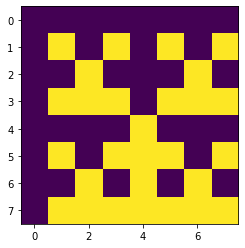

In [9]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(8
                        , 2, 2, 2, False,False,2,True,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]

In [4]:
def print_policy(Q_policy, env, val_1, val_2):
    val_2=0
    val_1=0
    j = []
    jv = []
    j1v = []
    el = env.maze.shape[0]
    ml = env.manager_view
    em = int(el / ml)
    lisv = []
    sm = []
    man_ag = {}
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])

    #          a is manager e.g. 3,3
    #  what's the equivalent for manager to pass when getting task

            man_ag[y * el + j2] = a[1][0] * (el/env.manager_view*(env.n_layers-1)) + a[1][1]
            if a[-1] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[-1])

    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        m = 1

        aa = env.possible_actions(m, [int(s / el), s % el])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, 1)

        t = 4
        state[el ** 2:2 * el ** 2] = 0
        state[el ** 2 + loc_idx2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + env.n_layers+1 + t] = 1
        #         print(state)

        j.append(action_dict[aa[torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[1].item()]])
        j1v.append(torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[0].item())
        jv.append([(x, Q_policy.forward(state, 1, env).flatten()[x].item()) for x in aa])
    print(np.array(j).reshape(em, em))
    print(np.array(jv).reshape(em, em))

    j2 = []
    j2v = []
    value_list = {}
    for s in range(el ** 2):

        #     if int(s/8)+s%8<16:
        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        #         aa=env.possible_actions(m,[int(s/8),s%8])
        state[el ** 2:2 * el ** 2] = val_2
        m = 2
    #     this is used to find task
        p = int(man_ag[s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
        t = action_dict_r[j[p]]
        gm = env.get_super_manager_1([int(s / el), int(s % el)])[1]
        for x in range(el ** 2):
            sm = env.get_super_manager_1([int(x / el), int(x % el)])[1]
            if sm == gm:
                state[el ** 2 + x] = 0

        state[s + el ** 2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + 3 + t] = 1
        #         print(p, s, m, t)
        #         print()
        #         print(state)
        if [int(s / el), int(s % el)] == env.goal_init_state:
            j2.append('X')
            j2v.append(0)
        elif env.maze[int(s / el), int(s % el)] == 1:
            vv = Q_policy.forward(state, 2, env)
            j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
        else:
            vv = Q_policy.forward(state, 2, env)
            value_list[s] = vv.cpu().detach().numpy()
            j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    print(np.array(j2).reshape(el, el
                               ))
    print('xxx')

    V = np.array(j1v)
    num_man = int(el / ml)
    cells = [[x, y] for x in range(num_man) for y in range(num_man)]
    policy = np.array(j).reshape(num_man, num_man)

    fig, ax = plt.subplots()
    im = ax.imshow(np.reshape(V, (-1, num_man)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        #     if env.good_cell[cell[0],cell[1]]==1:
        #         text = ax.text(cell[1], cell[0], "Ma",
        #                        ha="center", va="center", color="w")

        if cell == env.get_super_manager_1(env.goal_init_state)[1]:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w")
        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    plt.title('Policy Managerial level')

    plt.show()
    # print('cccc')

    # levlel_2_policy={x:action_map[2][x][t] for x in action_map[2].keys()}
    V = np.array(j2v)
    cells = [[x, y] for x in range(el) for y in range(el)]
    policy = np.array(j2).reshape(el, el)

    fig, ax = plt.subplots()
    V = np.sign(V) * (np.abs(V) ** 0.5)
    im = ax.imshow(np.reshape(V, (-1, el)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        if cell == env.goal_init_state:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w", weight='bold')
        elif env.maze[cell[0], cell[1]] == 1:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]] + '_M',
                           ha="center", va="center", color="w")

        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    fig.set_size_inches(18.5, 10.5)
    plt.title('Policy lower level')
    plt.show()
    print('cccc')

In [10]:



# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 3000
batch_size = 1
discount_factor =1
learn_rate = 1e-3
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_3={}
env1=copy.copy(env)

device = torch.device("cpu")

for man_init in ['Init']:
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
            clear_output(wait=True)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_3[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






  0%|                                                                                 | 1/3000 [00:00<41:07,  1.22it/s]

epsilon 0.15


  2%|█▍                                                                              | 52/3000 [01:25<06:00,  8.18it/s]

epsilon 0.15


  3%|██▋                                                                            | 103/3000 [01:31<03:05, 15.62it/s]

epsilon 0.15


  5%|████                                                                           | 152/3000 [01:34<03:38, 13.06it/s]

epsilon 0.15


  7%|█████▎                                                                         | 203/3000 [01:39<04:33, 10.23it/s]

epsilon 0.15


  8%|██████▋                                                                        | 254/3000 [01:43<03:10, 14.39it/s]

epsilon 0.15


 10%|███████▉                                                                       | 302/3000 [01:46<02:41, 16.74it/s]

epsilon 0.15


 12%|█████████▏                                                                     | 350/3000 [01:51<04:22, 10.10it/s]

epsilon 0.15
[6.093333333333334]
min mean 6.093333333333334
last mean 350    6.093333
dtype: float64


 13%|██████████▌                                                                    | 400/3000 [01:54<02:30, 17.32it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666]
min mean 5.526666666666666
last mean 400    5.563333
dtype: float64


 15%|███████████▉                                                                   | 451/3000 [01:59<03:55, 10.85it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667]
min mean 5.466666666666667
last mean 450    5.626667
dtype: float64


 17%|█████████████▏                                                                 | 500/3000 [02:02<02:07, 19.60it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333]
min mean 5.453333333333333
last mean 500    5.453333
dtype: float64


 18%|██████████████▍                                                                | 550/3000 [02:06<03:40, 11.12it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44]
min mean 5.44
last mean 550    5.53
dtype: float64


 20%|███████████████▊                                                               | 602/3000 [02:10<02:23, 16.66it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44]
min mean 5.44
last mean 600    5.626667
dtype: float64


 22%|█████████████████▏                                                             | 651/3000 [02:14<04:17,  9.12it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44]
min mean 5.44
last mean 650    5.623333
dtype: float64


 23%|██████████████████▌                                                            | 703/3000 [02:20<03:23, 11.29it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 700    5.866667
dtype: float64


 25%|███████████████████▊                                                           | 750/3000 [02:24<03:53,  9.62it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 750    5.72
dtype: float64


 27%|█████████████████████▏                                                         | 804/3000 [02:29<02:44, 13.35it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 800    5.98
dtype: float64


 28%|██████████████████████▍                                                        | 852/3000 [02:34<03:52,  9.24it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 850    6.15
dtype: float64


 30%|███████████████████████▊                                                       | 902/3000 [02:38<02:40, 13.03it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 900    6.166667
dtype: float64


 32%|█████████████████████████                                                      | 951/3000 [02:42<03:39,  9.33it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 950    6.133333
dtype: float64


 33%|██████████████████████████                                                    | 1003/3000 [02:46<02:57, 11.26it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1000    5.94
dtype: float64


 35%|███████████████████████████▍                                                  | 1053/3000 [02:52<05:04,  6.39it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1050    6.266667
dtype: float64


 37%|████████████████████████████▋                                                 | 1101/3000 [03:00<03:50,  8.24it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1100    7.056667
dtype: float64


 38%|█████████████████████████████▉                                                | 1153/3000 [03:05<02:57, 10.41it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1150    7.216667
dtype: float64


 40%|███████████████████████████████▎                                              | 1202/3000 [03:11<03:23,  8.83it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1200    7.453333
dtype: float64


 42%|████████████████████████████████▌                                             | 1250/3000 [03:16<04:47,  6.10it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1250    7.57
dtype: float64


 43%|█████████████████████████████████▉                                            | 1303/3000 [03:22<02:36, 10.82it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1300    7.633333
dtype: float64


 45%|███████████████████████████████████▏                                          | 1352/3000 [03:28<02:58,  9.22it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1350    7.46
dtype: float64


 47%|████████████████████████████████████▍                                         | 1401/3000 [03:33<03:14,  8.21it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1400    6.506667
dtype: float64


 48%|█████████████████████████████████████▊                                        | 1452/3000 [03:40<03:21,  7.69it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1450    6.413333
dtype: float64


 50%|███████████████████████████████████████                                       | 1502/3000 [03:45<02:22, 10.48it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1500    6.28
dtype: float64


 52%|████████████████████████████████████████▎                                     | 1552/3000 [03:50<02:45,  8.73it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1550    6.18
dtype: float64


 53%|█████████████████████████████████████████▋                                    | 1601/3000 [03:55<02:25,  9.60it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1600    6.186667
dtype: float64


 55%|██████████████████████████████████████████▉                                   | 1650/3000 [04:00<02:27,  9.17it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1650    6.14
dtype: float64


 57%|████████████████████████████████████████████▎                                 | 1703/3000 [04:05<01:53, 11.39it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1700    6.333333
dtype: float64


 58%|█████████████████████████████████████████████▌                                | 1752/3000 [04:10<01:55, 10.79it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1750    6.066667
dtype: float64


 60%|██████████████████████████████████████████████▉                               | 1803/3000 [04:16<02:11,  9.11it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1800    6.11
dtype: float64


 62%|████████████████████████████████████████████████▏                             | 1851/3000 [04:21<01:43, 11.15it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1850    6.153333
dtype: float64


 63%|█████████████████████████████████████████████████▍                            | 1903/3000 [04:26<01:41, 10.84it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1900    6.116667
dtype: float64


 65%|██████████████████████████████████████████████████▋                           | 1951/3000 [04:31<01:34, 11.14it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 1950    6.086667
dtype: float64


 67%|████████████████████████████████████████████████████                          | 2002/3000 [04:37<02:23,  6.93it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2000    6.053333
dtype: float64


 68%|█████████████████████████████████████████████████████▍                        | 2053/3000 [04:43<01:32, 10.27it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2050    6.103333
dtype: float64


 70%|██████████████████████████████████████████████████████▋                       | 2104/3000 [04:50<01:10, 12.65it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2100    6.026667
dtype: float64


 72%|███████████████████████████████████████████████████████▉                      | 2151/3000 [04:56<01:55,  7.37it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2150    6.08
dtype: float64


 73%|█████████████████████████████████████████████████████████▏                    | 2201/3000 [05:04<01:36,  8.26it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2200    6.43
dtype: float64


 75%|██████████████████████████████████████████████████████████▌                   | 2251/3000 [05:10<01:27,  8.56it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2250    6.58
dtype: float64


 77%|███████████████████████████████████████████████████████████▉                  | 2303/3000 [05:18<01:37,  7.17it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2300    6.693333
dtype: float64


 78%|█████████████████████████████████████████████████████████████▏                | 2352/3000 [05:23<01:06,  9.68it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2350    6.613333
dtype: float64


 80%|██████████████████████████████████████████████████████████████▍               | 2401/3000 [05:29<01:02,  9.52it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2400    6.53
dtype: float64


 82%|███████████████████████████████████████████████████████████████▊              | 2452/3000 [05:35<00:56,  9.73it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2450    6.39
dtype: float64


 83%|█████████████████████████████████████████████████████████████████             | 2502/3000 [05:40<00:46, 10.70it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2500    6.02
dtype: float64


 85%|██████████████████████████████████████████████████████████████████▎           | 2551/3000 [05:45<01:04,  6.93it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2550    5.936667
dtype: float64


 87%|███████████████████████████████████████████████████████████████████▋          | 2603/3000 [05:51<00:40,  9.91it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2600    5.733333
dtype: float64


 88%|████████████████████████████████████████████████████████████████████▉         | 2651/3000 [05:56<00:33, 10.37it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2650    5.85
dtype: float64


 90%|██████████████████████████████████████████████████████████████████████▎       | 2702/3000 [06:02<00:39,  7.51it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2700    6.043333
dtype: float64


 92%|███████████████████████████████████████████████████████████████████████▌      | 2752/3000 [06:08<00:23, 10.34it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2750    6.183333
dtype: float64


 93%|████████████████████████████████████████████████████████████████████████▉     | 2803/3000 [06:14<00:19, 10.28it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2800    6.353333
dtype: float64


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2852/3000 [06:19<00:13, 10.71it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2850    6.24
dtype: float64


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2902/3000 [06:25<00:10,  9.04it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2900    6.21
dtype: float64


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2951/3000 [06:31<00:05,  9.59it/s]

epsilon 0.15
[6.093333333333334, 5.526666666666666, 5.466666666666667, 5.453333333333333, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44, 5.44]
min mean 5.44
last mean 2950    6.123333
dtype: float64


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:36<00:00,  7.57it/s]


[['E' 'S' 'S' 'S']
 ['E' 'E' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'W']]
[[list([(0, -10.425443649291992), (1, -6.608908176422119), (2, -6.291464805603027), (3, -9.769736289978027)])
  list([(0, -11.327061653137207), (1, -4.2954607009887695), (2, -5.38698148727417), (3, -8.370283126831055)])
  list([(0, -9.036124229431152), (1, -2.156615734100342), (2, -6.613405704498291), (3, -6.401700496673584)])
  list([(0, -9.684925079345703), (1, -4.417377471923828), (2, -9.623963356018066), (3, -4.839148998260498)])]
 [list([(0, -7.642470836639404), (1, -6.115611553192139), (2, -4.31541109085083), (3, -8.731327056884766)])
  list([(0, -6.511733531951904), (1, -2.671513080596924), (2, -2.220670461654663), (3, -5.924001216888428)])
  list([(0, -4.487756252288818), (1, 0.10442924499511719), (2, -4.111523151397705), (3, -4.154552459716797)])
  list([(0, -6.622969627380371), (1, -3.084404945373535), (2, -8.102709770202637), (3, -2.379488468170166)])]
 [list([(0, -5.396057605743408), (1, -5.27

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['E' 'E' 'S' 'S' 'S' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S' 'S' 'S' 'S' 'S']
 ['E' 'E' 'E' 'E' 'S' 'S' 'W' 'W']
 ['E' 'E' 'E' 'E' 'S' 'S' 'W' 'W']
 ['E' 'E' 'E' 'E' 'X' 'W' 'W' 'W']
 ['E' 'E' 'E' 'E' 'N' 'W' 'W' 'W']
 ['E' 'E' 'N' 'N' 'N' 'N' 'W' 'W']
 ['E' 'E' 'N' 'N' 'N' 'N' 'W' 'W']]
xxx


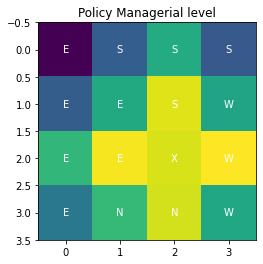

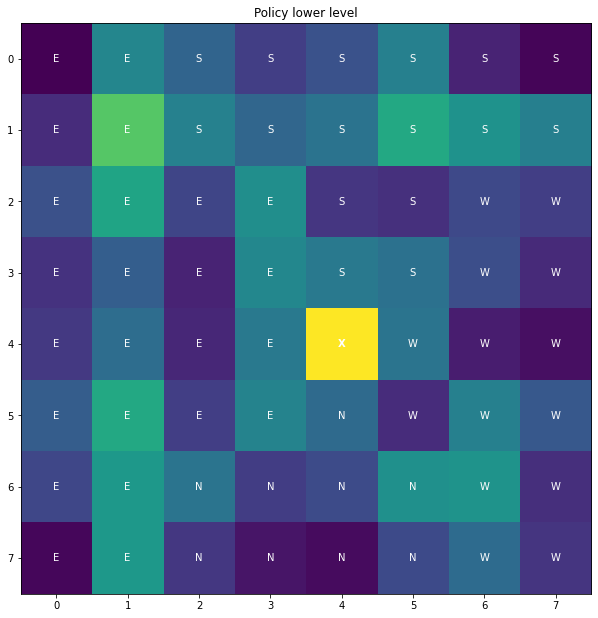

cccc


In [8]:
print_policy(Q_policy, env, 0,0)

  0%|                                                                                 | 1/5000 [00:00<27:05,  3.08it/s]

epsilon 0.79888


  1%|▋                                                                             | 48/5000 [02:13<1:06:49,  1.24it/s]

x


  1%|▊                                                                               | 53/5000 [02:15<47:29,  1.74it/s]

epsilon 0.7365


  2%|█▌                                                                           | 101/5000 [04:04<2:57:52,  2.18s/it]

epsilon 0.723


  3%|██▎                                                                          | 151/5000 [05:42<5:42:30,  4.24s/it]

epsilon 0.7095


  4%|███                                                                          | 201/5000 [06:58<1:32:49,  1.16s/it]

epsilon 0.696


  5%|███▊                                                                         | 251/5000 [08:13<2:13:16,  1.68s/it]

epsilon 0.6825


  6%|████▋                                                                        | 301/5000 [09:54<2:25:24,  1.86s/it]

epsilon 0.669


  7%|█████                                                                        | 327/5000 [10:31<4:18:05,  3.31s/it]

x


  7%|█████▏                                                                       | 337/5000 [10:50<2:51:11,  2.20s/it]

x


  7%|█████▌                                                                         | 351/5000 [11:02<53:58,  1.44it/s]

epsilon 0.6555
[81.43333333333334]
min mean 81.43333333333334
last mean 350    81.433333
dtype: float64


  7%|█████▋                                                                       | 368/5000 [11:25<1:36:33,  1.25s/it]

x


  8%|█████▊                                                                       | 375/5000 [11:31<1:17:29,  1.01s/it]

x


  8%|██████▏                                                                      | 401/5000 [12:09<1:46:50,  1.39s/it]

epsilon 0.642
[81.43333333333334, 67.17333333333333]
min mean 67.17333333333333
last mean 400    67.526667
dtype: float64


  9%|██████▉                                                                      | 452/5000 [13:25<1:14:15,  1.02it/s]

epsilon 0.6285000000000001
[81.43333333333334, 67.17333333333333, 60.63333333333333]
min mean 60.63333333333333
last mean 450    60.633333
dtype: float64


 10%|███████▍                                                                     | 486/5000 [14:13<2:36:07,  2.08s/it]

x


 10%|███████▋                                                                     | 500/5000 [14:35<2:39:57,  2.13s/it]

x


 10%|███████▋                                                                     | 501/5000 [14:36<2:01:24,  1.62s/it]

epsilon 0.615
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666]
min mean 58.406666666666666
last mean 500    59.203333
dtype: float64


 11%|████████▍                                                                    | 551/5000 [15:18<1:21:54,  1.10s/it]

epsilon 0.6014999999999999
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333]
min mean 54.82333333333333
last mean 550    54.823333
dtype: float64


 11%|████████▊                                                                      | 558/5000 [15:21<42:04,  1.76it/s]

x


 12%|█████████▍                                                                     | 601/5000 [16:00<52:43,  1.39it/s]

epsilon 0.588
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667]
min mean 46.97666666666667
last mean 600    46.976667
dtype: float64


 13%|██████████                                                                     | 639/5000 [16:37<50:28,  1.44it/s]

x


 13%|██████████                                                                   | 651/5000 [16:47<1:02:30,  1.16it/s]

epsilon 0.5745
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13]
min mean 44.13
last mean 650    44.423333
dtype: float64


 13%|██████████▏                                                                  | 663/5000 [16:58<1:08:56,  1.05it/s]

x


 14%|██████████▊                                                                    | 683/5000 [17:14<31:14,  2.30it/s]

x


 14%|███████████                                                                    | 702/5000 [17:23<23:53,  3.00it/s]

epsilon 0.5609999999999999
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666]
min mean 40.406666666666666
last mean 700    40.406667
dtype: float64


 14%|███████████▍                                                                   | 723/5000 [17:39<47:25,  1.50it/s]

x


 15%|███████████▊                                                                   | 751/5000 [17:55<37:02,  1.91it/s]

epsilon 0.5475
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34]
min mean 34.34
last mean 750    34.34
dtype: float64


 16%|████████████▋                                                                  | 800/5000 [18:36<44:06,  1.59it/s]

epsilon 0.534
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333]
min mean 30.043333333333333
last mean 800    30.043333
dtype: float64


 16%|████████████▌                                                                | 816/5000 [18:50<1:31:18,  1.31s/it]

x


 17%|█████████████▏                                                                 | 833/5000 [19:01<46:39,  1.49it/s]

x


 17%|█████████████▍                                                                 | 851/5000 [19:08<23:40,  2.92it/s]

x
epsilon 0.5205
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334]
min mean 28.913333333333334
last mean 850    28.913333
dtype: float64


 17%|█████████████▌                                                                 | 862/5000 [19:15<34:34,  1.99it/s]

x


 18%|██████████████▏                                                                | 901/5000 [19:38<53:20,  1.28it/s]

epsilon 0.507
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667]
min mean 26.956666666666667
last mean 900    27.496667
dtype: float64


 19%|██████████████▋                                                                | 929/5000 [19:54<45:01,  1.51it/s]

x


 19%|███████████████                                                                | 951/5000 [20:07<41:59,  1.61it/s]

epsilon 0.4935
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668]
min mean 25.986666666666668
last mean 950    26.08
dtype: float64


 20%|███████████████▌                                                              | 1001/5000 [20:30<37:53,  1.76it/s]

epsilon 0.48
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334]
min mean 24.433333333333334
last mean 1000    24.93
dtype: float64


 21%|████████████████▍                                                             | 1051/5000 [20:54<29:39,  2.22it/s]

epsilon 0.4665
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332]
min mean 24.173333333333332
last mean 1050    24.506667
dtype: float64


 22%|█████████████████                                                             | 1091/5000 [21:12<43:34,  1.50it/s]

x


 22%|█████████████████▏                                                            | 1101/5000 [21:17<38:16,  1.70it/s]

epsilon 0.45299999999999996
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333]
min mean 22.60333333333333
last mean 1100    22.826667
dtype: float64


 23%|█████████████████▉                                                            | 1151/5000 [21:39<21:57,  2.92it/s]

epsilon 0.4395
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667]
min mean 22.026666666666667
last mean 1150    22.136667
dtype: float64


 23%|█████████████████▉                                                            | 1152/5000 [21:40<31:33,  2.03it/s]

x


 24%|██████████████████▋                                                           | 1201/5000 [22:03<18:14,  3.47it/s]

epsilon 0.426
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667]
min mean 21.726666666666667
last mean 1200    21.726667
dtype: float64


 25%|███████████████████▏                                                          | 1232/5000 [22:17<33:50,  1.86it/s]

x


 25%|███████████████████▌                                                          | 1253/5000 [22:23<12:23,  5.04it/s]

epsilon 0.4125
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334]
min mean 20.233333333333334
last mean 1250    20.233333
dtype: float64


 26%|████████████████████▎                                                         | 1301/5000 [22:42<16:49,  3.66it/s]

epsilon 0.39899999999999997
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665]
min mean 19.376666666666665
last mean 1300    19.376667
dtype: float64


 27%|████████████████████▉                                                         | 1346/5000 [22:58<26:36,  2.29it/s]

x


 27%|█████████████████████                                                         | 1351/5000 [23:01<33:30,  1.81it/s]

epsilon 0.3855
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667]
min mean 18.206666666666667
last mean 1350    18.453333
dtype: float64


 28%|█████████████████████▊                                                        | 1401/5000 [23:19<21:30,  2.79it/s]

epsilon 0.372
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332]
min mean 17.743333333333332
last mean 1400    17.743333
dtype: float64


 29%|██████████████████████▋                                                       | 1451/5000 [23:39<24:20,  2.43it/s]

epsilon 0.3585
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8]
min mean 16.8
last mean 1450    17.19
dtype: float64


 30%|███████████████████████▍                                                      | 1502/5000 [23:57<13:18,  4.38it/s]

epsilon 0.345
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334]
min mean 16.143333333333334
last mean 1500    16.4
dtype: float64


 31%|████████████████████████▏                                                     | 1550/5000 [24:13<16:45,  3.43it/s]

epsilon 0.33149999999999996
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334]
min mean 15.333333333333334
last mean 1550    15.646667
dtype: float64


 32%|████████████████████████▉                                                     | 1601/5000 [24:27<18:41,  3.03it/s]

epsilon 0.31800000000000006
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06]
min mean 15.06
last mean 1600    15.206667
dtype: float64


 33%|█████████████████████████▊                                                    | 1651/5000 [24:45<18:47,  2.97it/s]

epsilon 0.3045
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667]
min mean 14.946666666666667
last mean 1650    14.98
dtype: float64


 34%|██████████████████████████▌                                                   | 1702/5000 [25:01<10:41,  5.14it/s]

epsilon 0.29100000000000004
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334]
min mean 14.583333333333334
last mean 1700    14.583333
dtype: float64


 35%|███████████████████████████▎                                                  | 1751/5000 [25:17<16:29,  3.28it/s]

epsilon 0.27749999999999997
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95]
min mean 13.95
last mean 1750    14.06
dtype: float64


 36%|████████████████████████████                                                  | 1800/5000 [25:33<17:16,  3.09it/s]

epsilon 0.264
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667]
min mean 13.466666666666667
last mean 1800    13.676667
dtype: float64


 37%|████████████████████████████▉                                                 | 1851/5000 [25:46<15:00,  3.50it/s]

epsilon 0.25049999999999994
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16]
min mean 13.16
last mean 1850    13.253333
dtype: float64


 38%|█████████████████████████████▎                                                | 1879/5000 [25:53<17:45,  2.93it/s]

x


 38%|█████████████████████████████▋                                                | 1901/5000 [25:58<12:31,  4.12it/s]

epsilon 0.237
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68]
min mean 12.68
last mean 1900    12.693333
dtype: float64


 39%|██████████████████████████████▍                                               | 1952/5000 [26:13<12:50,  3.96it/s]

epsilon 0.22350000000000003
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22]
min mean 12.22
last mean 1950    12.22
dtype: float64


 40%|███████████████████████████████▏                                              | 2002/5000 [26:25<09:41,  5.15it/s]

epsilon 0.20999999999999996
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666]
min mean 11.486666666666666
last mean 2000    11.536667
dtype: float64


 41%|████████████████████████████████                                              | 2053/5000 [26:40<13:10,  3.73it/s]

epsilon 0.1965
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334]
min mean 10.903333333333334
last mean 2050    11.02
dtype: float64


 41%|████████████████████████████████                                              | 2055/5000 [26:41<16:53,  2.91it/s]

x


 42%|████████████████████████████████▊                                             | 2102/5000 [26:53<08:12,  5.89it/s]

epsilon 0.18300000000000005
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41]
min mean 10.41
last mean 2100    10.423333
dtype: float64


 43%|█████████████████████████████████▌                                            | 2151/5000 [27:03<08:18,  5.71it/s]

epsilon 0.16949999999999998
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333]
min mean 9.973333333333333
last mean 2150    9.973333
dtype: float64


 44%|██████████████████████████████████▎                                           | 2203/5000 [27:14<07:53,  5.91it/s]

epsilon 0.15599999999999992
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334]
min mean 9.823333333333334
last mean 2200    9.913333
dtype: float64


 45%|███████████████████████████████████                                           | 2251/5000 [27:24<11:02,  4.15it/s]

epsilon 0.14249999999999996
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334]
min mean 9.243333333333334
last mean 2250    9.296667
dtype: float64


 46%|███████████████████████████████████▉                                          | 2302/5000 [27:36<08:32,  5.26it/s]

epsilon 0.129
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15]
min mean 9.15
last mean 2300    9.293333
dtype: float64


 47%|████████████████████████████████████▋                                         | 2352/5000 [27:47<08:02,  5.49it/s]

epsilon 0.11550000000000005
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334]
min mean 9.013333333333334
last mean 2350    9.013333
dtype: float64


 48%|█████████████████████████████████████▍                                        | 2400/5000 [27:57<09:33,  4.54it/s]

epsilon 0.10199999999999998
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334]
min mean 8.653333333333334
last mean 2400    8.713333
dtype: float64


 49%|██████████████████████████████████████▏                                       | 2451/5000 [28:06<07:15,  5.85it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56]
min mean 8.56
last mean 2450    8.583333
dtype: float64


 50%|███████████████████████████████████████                                       | 2501/5000 [28:14<06:40,  6.24it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334]
min mean 8.163333333333334
last mean 2500    8.163333
dtype: float64


 50%|███████████████████████████████████████▏                                      | 2510/5000 [28:16<07:04,  5.86it/s]

x


 51%|███████████████████████████████████████▊                                      | 2551/5000 [28:23<07:54,  5.17it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333]
min mean 7.863333333333333
last mean 2550    7.896667
dtype: float64


 51%|███████████████████████████████████████▉                                      | 2561/5000 [28:25<08:14,  4.93it/s]

x


 52%|████████████████████████████████████████▌                                     | 2601/5000 [28:32<06:37,  6.04it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49]
min mean 7.49
last mean 2600    7.496667
dtype: float64


 53%|█████████████████████████████████████████▎                                    | 2651/5000 [28:40<08:23,  4.67it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333]
min mean 7.043333333333333
last mean 2650    7.066667
dtype: float64


 54%|██████████████████████████████████████████▏                                   | 2701/5000 [28:50<08:09,  4.70it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334]
min mean 7.013333333333334
last mean 2700    7.153333
dtype: float64


 55%|██████████████████████████████████████████▉                                   | 2751/5000 [28:59<06:22,  5.87it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667]
min mean 6.966666666666667
last mean 2750    7.013333
dtype: float64


 56%|███████████████████████████████████████████▋                                  | 2802/5000 [29:09<05:57,  6.16it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333]
min mean 6.913333333333333
last mean 2800    7.18
dtype: float64


 57%|████████████████████████████████████████████▌                                 | 2853/5000 [29:19<10:18,  3.47it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333]
min mean 6.913333333333333
last mean 2850    7.28
dtype: float64


 58%|█████████████████████████████████████████████▎                                | 2903/5000 [29:30<04:34,  7.65it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333]
min mean 6.913333333333333
last mean 2900    7.206667
dtype: float64


 59%|██████████████████████████████████████████████                                | 2951/5000 [29:38<05:39,  6.03it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333]
min mean 6.913333333333333
last mean 2950    7.143333
dtype: float64


 60%|██████████████████████████████████████████████▊                               | 3002/5000 [29:47<07:16,  4.58it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333]
min mean 6.913333333333333
last mean 3000    7.096667
dtype: float64


 60%|██████████████████████████████████████████████▉                               | 3008/5000 [29:48<06:16,  5.30it/s]

x


 61%|███████████████████████████████████████████████▌                              | 3052/5000 [29:55<05:13,  6.22it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333]
min mean 6.913333333333333
last mean 3050    7.073333
dtype: float64


 62%|████████████████████████████████████████████████▍                             | 3101/5000 [30:03<06:08,  5.15it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85]
min mean 6.85
last mean 3100    6.883333
dtype: float64


 63%|█████████████████████████████████████████████████▏                            | 3152/5000 [30:10<05:19,  5.79it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667]
min mean 6.626666666666667
last mean 3150   

 64%|█████████████████████████████████████████████████▉                            | 3200/5000 [30:17<03:43,  8.04it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46]
min mean 6.46
last mean 3200    6.4733

 64%|██████████████████████████████████████████████████                            | 3210/5000 [30:18<03:49,  7.79it/s]

x


 64%|██████████████████████████████████████████████████                            | 3213/5000 [30:19<04:05,  7.28it/s]

x


 64%|██████████████████████████████████████████████████▏                           | 3218/5000 [30:19<04:08,  7.18it/s]

x


 65%|██████████████████████████████████████████████████▋                           | 3251/5000 [30:24<03:41,  7.89it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335]
min mean 6.3933333

 65%|██████████████████████████████████████████████████▊                           | 3257/5000 [30:25<03:42,  7.82it/s]

x


 66%|███████████████████████████████████████████████████▍                          | 3301/5000 [30:32<04:24,  6.41it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334]

 67%|████████████████████████████████████████████████████▎                         | 3352/5000 [30:40<04:31,  6.07it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 68%|█████████████████████████████████████████████████████                         | 3402/5000 [30:47<03:37,  7.36it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 69%|█████████████████████████████████████████████████████▍                        | 3428/5000 [30:51<04:54,  5.34it/s]

x


 69%|█████████████████████████████████████████████████████▊                        | 3450/5000 [30:54<03:19,  7.76it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 70%|██████████████████████████████████████████████████████▋                       | 3503/5000 [31:02<03:29,  7.13it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 71%|███████████████████████████████████████████████████████▍                      | 3551/5000 [31:09<04:39,  5.18it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 71%|███████████████████████████████████████████████████████▍                      | 3557/5000 [31:10<04:26,  5.41it/s]

x


 72%|████████████████████████████████████████████████████████▏                     | 3601/5000 [31:17<03:31,  6.62it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 73%|████████████████████████████████████████████████████████▉                     | 3651/5000 [31:24<03:50,  5.85it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 73%|█████████████████████████████████████████████████████████▏                    | 3667/5000 [31:27<04:00,  5.54it/s]

x


 74%|█████████████████████████████████████████████████████████▊                    | 3702/5000 [31:32<03:17,  6.56it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 75%|██████████████████████████████████████████████████████████▌                   | 3751/5000 [31:40<03:02,  6.83it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 76%|███████████████████████████████████████████████████████████▎                  | 3802/5000 [31:47<03:14,  6.16it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 77%|████████████████████████████████████████████████████████████                  | 3851/5000 [31:54<02:17,  8.37it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 78%|████████████████████████████████████████████████████████████▊                 | 3901/5000 [32:02<03:32,  5.17it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 79%|█████████████████████████████████████████████████████████████▋                | 3952/5000 [32:09<02:50,  6.13it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 80%|██████████████████████████████████████████████████████████████▍               | 4001/5000 [32:18<02:30,  6.65it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 81%|███████████████████████████████████████████████████████████████▏              | 4052/5000 [32:26<02:25,  6.50it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 82%|███████████████████████████████████████████████████████████████▉              | 4101/5000 [32:34<02:19,  6.47it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 83%|████████████████████████████████████████████████████████████████▊             | 4151/5000 [32:42<02:38,  5.37it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 84%|█████████████████████████████████████████████████████████████████▌            | 4201/5000 [32:51<02:13,  5.97it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 85%|██████████████████████████████████████████████████████████████████▎           | 4251/5000 [32:59<02:37,  4.74it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 86%|███████████████████████████████████████████████████████████████████           | 4301/5000 [33:07<01:36,  7.24it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 87%|███████████████████████████████████████████████████████████████████▉          | 4351/5000 [33:14<01:53,  5.70it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 88%|████████████████████████████████████████████████████████████████████▋         | 4402/5000 [33:22<01:26,  6.92it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 89%|█████████████████████████████████████████████████████████████████████▍        | 4451/5000 [33:30<01:47,  5.09it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 90%|██████████████████████████████████████████████████████████████████████▏       | 4501/5000 [33:39<01:25,  5.84it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 91%|██████████████████████████████████████████████████████████████████████▉       | 4551/5000 [33:48<01:22,  5.43it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 92%|███████████████████████████████████████████████████████████████████████▌      | 4590/5000 [33:53<01:03,  6.45it/s]

x


 92%|███████████████████████████████████████████████████████████████████████▊      | 4602/5000 [33:55<01:01,  6.52it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 93%|████████████████████████████████████████████████████████████████████████▌     | 4652/5000 [34:04<01:06,  5.26it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4702/5000 [34:12<00:48,  6.20it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 95%|██████████████████████████████████████████████████████████████████████████▏   | 4752/5000 [34:22<00:45,  5.45it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4802/5000 [34:31<00:35,  5.58it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4851/5000 [34:39<00:27,  5.39it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4901/5000 [34:48<00:17,  5.60it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

 98%|████████████████████████████████████████████████████████████████████████████▋ | 4917/5000 [34:51<00:12,  6.39it/s]

x


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4951/5000 [34:57<00:08,  5.98it/s]

epsilon 0.1
[81.43333333333334, 67.17333333333333, 60.63333333333333, 58.406666666666666, 54.82333333333333, 46.97666666666667, 44.13, 40.406666666666666, 34.34, 30.043333333333333, 28.913333333333334, 26.956666666666667, 25.986666666666668, 24.433333333333334, 24.173333333333332, 22.60333333333333, 22.026666666666667, 21.726666666666667, 20.233333333333334, 19.376666666666665, 18.206666666666667, 17.743333333333332, 16.8, 16.143333333333334, 15.333333333333334, 15.06, 14.946666666666667, 14.583333333333334, 13.95, 13.466666666666667, 13.16, 12.68, 12.22, 11.486666666666666, 10.903333333333334, 10.41, 9.973333333333333, 9.823333333333334, 9.243333333333334, 9.15, 9.013333333333334, 8.653333333333334, 8.56, 8.163333333333334, 7.863333333333333, 7.49, 7.043333333333333, 7.013333333333334, 6.966666666666667, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.913333333333333, 6.85, 6.626666666666667, 6.46, 6.3933333333333335, 6.263333333333334,

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [35:05<00:00,  2.37it/s]


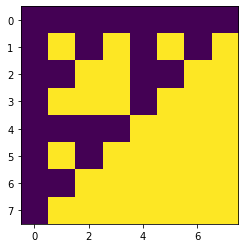

In [5]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(8
                        , 2, 2, 2, False,True,2,True,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]


# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 5000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_4={}
env2=copy.copy(env)
device = torch.device("cpu")

for man_init in ['Init','Nil','Exact','Learn']:
    print(man_init)
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
            clear_output(wait=True)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_4[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards),'ss':copy.copy(ss) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






[4, 6]
[[0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


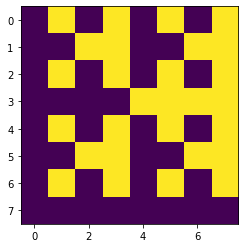

In [6]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(8
                        , 2, 2, 2, False,False,2,True,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]

r_dict_5={}

# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 5000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cpu")
env3=copy.copy(env)

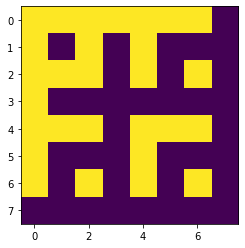

In [14]:
plt.imshow(env.maze)

In [22]:
r_d

dict_keys([0, 1, 2, 3])

In [11]:
# r_dict_5[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
#                              'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
# counter=counter+1

In [7]:


for man_init in ['Learn','Init','Nil','Exact']:
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
            clear_output(wait=True)
            print(man_init)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_5[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

Exact


  0%|                                                                               | 1/5000 [00:03<4:31:50,  3.26s/it]

epsilon 0.7829333333333334


  1%|▍                                                                             | 26/5000 [00:28<1:39:19,  1.20s/it]

x


  1%|▍                                                                             | 29/5000 [00:32<1:50:40,  1.34s/it]

x


  1%|▊                                                                             | 51/5000 [00:57<1:30:50,  1.10s/it]

epsilon 0.7365


  2%|█▌                                                                             | 101/5000 [01:34<43:38,  1.87it/s]

epsilon 0.723


  3%|██                                                                             | 127/5000 [02:00<52:08,  1.56it/s]

x


  3%|██▎                                                                          | 151/5000 [02:23<1:31:07,  1.13s/it]

epsilon 0.7095


  4%|███                                                                          | 201/5000 [03:09<1:18:55,  1.01it/s]

epsilon 0.696


  4%|███▍                                                                         | 220/5000 [03:28<1:50:08,  1.38s/it]

x


  5%|███▉                                                                           | 251/5000 [03:49<54:55,  1.44it/s]

epsilon 0.6825


  5%|████▏                                                                          | 267/5000 [03:56<34:18,  2.30it/s]

x


  6%|████▊                                                                          | 301/5000 [04:14<38:20,  2.04it/s]

epsilon 0.669
x


  6%|████▉                                                                          | 310/5000 [04:21<45:17,  1.73it/s]

x


  7%|█████▌                                                                         | 350/5000 [04:38<45:15,  1.71it/s]

epsilon 0.6555
[71.29333333333334]
min mean 71.29333333333334
last mean 350    71.453333
dtype: float64


  8%|█████▉                                                                         | 375/5000 [04:43<15:40,  4.92it/s]

x


  8%|██████▎                                                                        | 401/5000 [04:56<36:51,  2.08it/s]

epsilon 0.642
[71.29333333333334, 64.58333333333333]
min mean 64.58333333333333
last mean 400    65.203333
dtype: float64


  8%|██████▍                                                                        | 409/5000 [05:02<35:00,  2.19it/s]

x


  9%|██████▊                                                                        | 429/5000 [05:08<15:52,  4.80it/s]

x


  9%|███████▏                                                                       | 453/5000 [05:18<30:26,  2.49it/s]

epsilon 0.6285000000000001
[71.29333333333334, 64.58333333333333, 56.71333333333333]
min mean 56.71333333333333
last mean 450    56.713333
dtype: float64


 10%|███████▉                                                                       | 500/5000 [05:37<37:46,  1.99it/s]

epsilon 0.615
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97]
min mean 47.97
last mean 500    47.97
dtype: float64


 11%|████████▋                                                                      | 551/5000 [05:59<32:24,  2.29it/s]

epsilon 0.6014999999999999
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667]
min mean 41.18666666666667
last mean 550    42.153333
dtype: float64


 12%|█████████▍                                                                     | 601/5000 [06:21<34:32,  2.12it/s]

epsilon 0.588
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74]
min mean 40.74
last mean 600    41.016667
dtype: float64


 13%|██████████▎                                                                    | 651/5000 [06:37<19:06,  3.79it/s]

epsilon 0.5745
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22]
min mean 38.22
last mean 650    38.303333
dtype: float64


 14%|██████████▊                                                                    | 681/5000 [06:49<44:39,  1.61it/s]

x


 14%|██████████▉                                                                    | 689/5000 [06:50<14:38,  4.91it/s]

x


 14%|██████████▉                                                                    | 692/5000 [06:52<41:54,  1.71it/s]

x


 14%|███████████                                                                    | 701/5000 [06:55<24:28,  2.93it/s]

epsilon 0.5609999999999999
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334]
min mean 38.11333333333334
last mean 700    38.41
dtype: float64


 15%|███████████▊                                                                   | 751/5000 [07:09<18:44,  3.78it/s]

epsilon 0.5475
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69]
min mean 35.69
last mean 750    35.69
dtype: float64


 16%|████████████▋                                                                  | 800/5000 [07:21<17:11,  4.07it/s]

epsilon 0.534
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9]
min mean 32.9
last mean 800    32.9
dtype: float64


 17%|█████████████▎                                                                 | 840/5000 [07:29<22:54,  3.03it/s]

x


 17%|█████████████▍                                                                 | 850/5000 [07:31<15:14,  4.54it/s]

epsilon 0.5205
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332]
min mean 28.993333333333332
last mean 850    28.993333
dtype: float64


 18%|██████████████▏                                                                | 901/5000 [07:44<18:29,  3.69it/s]

epsilon 0.507
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335]
min mean 25.713333333333335
last mean 900    26.106667
dtype: float64


 19%|███████████████                                                                | 953/5000 [07:56<18:44,  3.60it/s]

epsilon 0.4935
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52]
min mean 24.52
last mean 950    24.833333
dtype: float64


 20%|███████████████▋                                                              | 1002/5000 [08:04<09:45,  6.83it/s]

epsilon 0.48
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667]
min mean 21.476666666666667
last mean 1000    21.476667
dtype: float64


 21%|████████████████▍                                                             | 1051/5000 [08:17<16:47,  3.92it/s]

epsilon 0.4665
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38]
min mean 20.38
last mean 1050    20.796667
dtype: float64


 22%|█████████████████▏                                                            | 1100/5000 [08:27<14:58,  4.34it/s]

epsilon 0.45299999999999996
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667]
min mean 20.14666666666667
last mean 1100    20.306667
dtype: float64


 23%|█████████████████▉                                                            | 1150/5000 [08:39<10:23,  6.17it/s]

epsilon 0.4395
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666]
min mean 20.106666666666666
last mean 1150    20.82
dtype: float64


 23%|█████████████████▉                                                            | 1152/5000 [08:40<09:47,  6.55it/s]

x


 24%|██████████████████▍                                                           | 1183/5000 [08:46<10:09,  6.26it/s]

x


 24%|██████████████████▊                                                           | 1203/5000 [08:51<11:20,  5.58it/s]

epsilon 0.426
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332]
min mean 20.083333333333332
last mean 1200    20.093333
dtype: float64


 24%|███████████████████                                                           | 1223/5000 [08:54<06:26,  9.76it/s]

x


 25%|███████████████████▌                                                          | 1251/5000 [09:01<18:10,  3.44it/s]

epsilon 0.4125
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48]
min mean 19.48
last mean 1250    19.606667
dtype: float64


 26%|████████████████████▎                                                         | 1302/5000 [09:14<17:42,  3.48it/s]

epsilon 0.39899999999999997
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48]
min mean 19.48
last mean 1300    20.603333
dtype: float64


 27%|█████████████████████                                                         | 1351/5000 [09:23<13:12,  4.61it/s]

epsilon 0.3855
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48]
min mean 19.48
last mean 1350    19.623333
dtype: float64


 28%|█████████████████████▊                                                        | 1401/5000 [09:34<11:26,  5.24it/s]

epsilon 0.372
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332]
min mean 19.263333333333332
last mean 1400    19.766667
dtype: float64


 29%|██████████████████████▋                                                       | 1451/5000 [09:45<11:47,  5.02it/s]

epsilon 0.3585
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666]
min mean 18.836666666666666
last mean 1450    19.336667
dtype: float64


 30%|███████████████████████▍                                                      | 1501/5000 [09:53<10:24,  5.60it/s]

epsilon 0.345
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44]
min mean 18.44
last mean 1500    18.523333
dtype: float64


 31%|████████████████████████▏                                                     | 1549/5000 [10:04<13:19,  4.32it/s]

epsilon 0.33149999999999996
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44]
min mean 18.44
last mean 1550    18.473333
dtype: float64


 32%|████████████████████████▊                                                     | 1594/5000 [10:11<07:59,  7.10it/s]

x


 32%|████████████████████████▉                                                     | 1601/5000 [10:13<15:50,  3.58it/s]

epsilon 0.31800000000000006
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334]
min mean 17.253333333333334
last mean 1600    17.253333
dtype: float64


 33%|█████████████████████████▊                                                    | 1651/5000 [10:22<10:40,  5.23it/s]

epsilon 0.3045
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334]
min mean 16.933333333333334
last mean 1650    17.046667
dtype: float64


 33%|█████████████████████████▉                                                    | 1666/5000 [10:24<10:23,  5.35it/s]

x


 34%|██████████████████████████▌                                                   | 1702/5000 [10:31<09:33,  5.75it/s]

epsilon 0.29100000000000004
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666]
min mean 16.266666666666666
last mean 1700    16.3
dtype: float64


 35%|███████████████████████████▎                                                  | 1751/5000 [10:39<10:50,  4.99it/s]

epsilon 0.27749999999999997
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667]
min mean 15.296666666666667
last mean 1750    15.343333
dtype: float64


 36%|████████████████████████████                                                  | 1801/5000 [10:49<10:18,  5.17it/s]

x
epsilon 0.264
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667]
min mean 15.296666666666667
last mean 1800    15.726667
dtype: float64


 37%|████████████████████████████▋                                                 | 1838/5000 [10:54<07:10,  7.35it/s]

x


 37%|████████████████████████████▉                                                 | 1852/5000 [10:56<10:28,  5.01it/s]

epsilon 0.25049999999999994
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667]
min mean 14.476666666666667
last mean 1850    14.643333
dtype: float64


 38%|█████████████████████████████▋                                                | 1901/5000 [11:04<07:57,  6.49it/s]

epsilon 0.237
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46]
min mean 14.46
last mean 1900    14.493333
dtype: float64


 39%|██████████████████████████████▏                                               | 1934/5000 [11:09<06:04,  8.41it/s]

x


 39%|██████████████████████████████▍                                               | 1951/5000 [11:11<08:52,  5.72it/s]

epsilon 0.22350000000000003
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92]
min mean 13.92
last mean 1950    13.97
dtype: float64


 40%|███████████████████████████████▏                                              | 2001/5000 [11:18<05:35,  8.94it/s]

epsilon 0.20999999999999996
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667]
min mean 13.366666666666667
last mean 2000    13.376667
dtype: float64


 41%|███████████████████████████████▉                                              | 2051/5000 [11:26<06:10,  7.95it/s]

epsilon 0.1965
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333]
min mean 13.043333333333333
last mean 2050    13.09
dtype: float64


 42%|████████████████████████████████▊                                             | 2103/5000 [11:33<06:10,  7.82it/s]

epsilon 0.18300000000000005
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333]
min mean 12.123333333333333
last mean 2100    12.143333
dtype: float64


 43%|█████████████████████████████████▌                                            | 2154/5000 [11:40<04:40, 10.14it/s]

epsilon 0.16949999999999998
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334]
min mean 11.653333333333334
last mean 2150    11.673333
dtype: float64


 44%|██████████████████████████████████▎                                           | 2200/5000 [11:45<05:03,  9.21it/s]

epsilon 0.15599999999999992
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666]
min mean 10.826666666666666
last mean 2200    10.826667
dtype: float64


 45%|███████████████████████████████████▏                                          | 2252/5000 [11:50<05:36,  8.18it/s]

epsilon 0.14249999999999996
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21]
min mean 10.21
last mean 2250    10.243333
dtype: float64


 46%|███████████████████████████████████▉                                          | 2301/5000 [11:56<06:26,  6.99it/s]

epsilon 0.129
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334]
min mean 9.593333333333334
last mean 2300    9.81
dtype: float64


 47%|████████████████████████████████████▋                                         | 2353/5000 [12:02<05:25,  8.14it/s]

epsilon 0.11550000000000005
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333]
min mean 9.303333333333333
last mean 2350    9.423333
dtype: float64


 48%|█████████████████████████████████████▍                                        | 2402/5000 [12:08<05:09,  8.40it/s]

epsilon 0.10199999999999998
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334]
min mean 9.013333333333334
last mean 2400    9.103333
dtype: float64


 49%|██████████████████████████████████████▎                                       | 2452/5000 [12:13<03:44, 11.33it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667]
min mean 8.806666666666667
last mean 2450    8.816667
dtype: float64


 50%|███████████████████████████████████████                                       | 2500/5000 [12:19<03:52, 10.74it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333]
min mean 8.803333333333333
last mean 2500    8.923333
dtype: float64


 51%|███████████████████████████████████████▊                                      | 2552/5000 [12:24<06:04,  6.72it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333]
min mean 8.803333333333333
last mean 2550    8.986667
dtype: float64


 52%|████████████████████████████████████████▌                                     | 2603/5000 [12:30<03:37, 11.00it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333]
min mean 8.803333333333333
last mean 2600    9.146667
dtype: float64


 53%|█████████████████████████████████████████▍                                    | 2653/5000 [12:34<03:31, 11.09it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667]
min mean 8.606666666666667
last mean 2650    8.646667
dtype: float64


 54%|██████████████████████████████████████████▏                                   | 2701/5000 [12:39<03:53,  9.85it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26]
min mean 8.26
last mean 2700    8.313333
dtype: float64


 55%|██████████████████████████████████████████▉                                   | 2749/5000 [12:44<04:13,  8.88it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333]
min mean 8.193333333333333
last mean 2750    8.333333
dtype: float64


 56%|███████████████████████████████████████████▋                                  | 2804/5000 [12:49<03:12, 11.41it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08]
min mean 8.08
last mean 2800    8.136667
dtype: float64


 57%|████████████████████████████████████████████▌                                 | 2854/5000 [12:54<03:47,  9.41it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333]
min mean 7.913333333333333
last mean 2850    7.99
dtype: float64


 58%|█████████████████████████████████████████████▎                                | 2902/5000 [12:59<03:14, 10.76it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6]
min mean 7.6
last mean 2900    7.606667
dtype: float64


 59%|██████████████████████████████████████████████                                | 2952/5000 [13:04<03:38,  9.39it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6]
min mean 7.6
last mean 2950    7.73
dtype: float64


 60%|██████████████████████████████████████████████▊                               | 3001/5000 [13:08<03:16, 10.17it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6]
min mean 7.6
last mean 3000    7.746667
dtype: float64


 61%|███████████████████████████████████████████████▌                              | 3051/5000 [13:13<03:30,  9.27it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333]
min mean 7.483333333333333
last mean 3050    7.63
dtype: float64


 62%|████████████████████████████████████████████████▍                             | 3102/5000 [13:18<03:31,  8.95it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333]
min mean 7.453333333333333
last mean 3100    7.576667
dtype: float64


 63%|█████████████████████████████████████████████████▏                            | 3153/5000 [13:23<02:56, 10.49it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333]
min mean 7.453333333333333
last mean 3150    7.476667
dtype: float64


 64%|█████████████████████████████████████████████████▉                            | 3203/5000 [13:27<02:23, 12.54it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44]
min mean 7.44
last mean 3200    7.46
dtype: float64


 65%|██████████████████████████████████████████████████▋                           | 3251/5000 [13:31<02:30, 11.61it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22]
min mean 7.22
last mean 3250    7.23
dtype: float64


 66%|███████████████████████████████████████████████████▌                          | 3302/5000 [13:37<03:18,  8.56it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06]
min mean 7.06
last mean 3300    7.153333
dtype: float64


 67%|████████████████████████████████████████████████████▎                         | 3353/5000 [13:41<02:24, 11.38it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06]
min mean 7.06
last mean 3350    7.176667
dtype: float64


 68%|█████████████████████████████████████████████████████                         | 3401/5000 [13:45<02:12, 12.05it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84]
min mean 6.84
last mean 3400    6.85
dtype: float64


 69%|█████████████████████████████████████████████████████▊                        | 3453/5000 [13:50<01:52, 13.71it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67]
min mean 6.67
last mean 3450    6.67
dtype: float64


 70%|██████████████████████████████████████████████████████▋                       | 3502/5000 [13:54<02:34,  9.72it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667]
min mean 6.466666666666667
last mean 3500    6.576667
dtype: float64


 71%|███████████████████████████████████████████████████████                       | 3530/5000 [13:57<02:07, 11.54it/s]

x


 71%|███████████████████████████████████████████████████████▍                      | 3552/5000 [13:59<02:39,  9.10it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667]
min mean 6.466666666666667
last mean 3550    6.683333
dtype: 

 72%|████████████████████████████████████████████████████████▏                     | 3602/5000 [14:04<02:18, 10.07it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667]
min mean 6.466666666666667
last mean 3600 

 73%|████████████████████████████████████████████████████████▉                     | 3652/5000 [14:09<02:14,  9.99it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667]
min mean 6.426666666666

 74%|█████████████████████████████████████████████████████████▊                    | 3702/5000 [14:14<02:13,  9.75it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667]
min 

 75%|██████████████████████████████████████████████████████████▌                   | 3752/5000 [14:18<01:45, 11.80it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 76%|███████████████████████████████████████████████████████████▎                  | 3803/5000 [14:23<01:57, 10.20it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 77%|████████████████████████████████████████████████████████████                  | 3851/5000 [14:28<01:33, 12.31it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 78%|████████████████████████████████████████████████████████████▉                 | 3903/5000 [14:32<01:47, 10.25it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 79%|█████████████████████████████████████████████████████████████▋                | 3953/5000 [14:37<01:49,  9.59it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 80%|██████████████████████████████████████████████████████████████▍               | 4001/5000 [14:42<01:30, 11.07it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 81%|███████████████████████████████████████████████████████████████▏              | 4052/5000 [14:47<01:28, 10.68it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 82%|███████████████████████████████████████████████████████████████▉              | 4102/5000 [14:51<01:33,  9.65it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 83%|████████████████████████████████████████████████████████████████▊             | 4151/5000 [14:56<01:27,  9.75it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 84%|█████████████████████████████████████████████████████████████████▌            | 4201/5000 [15:01<01:28,  9.05it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 85%|██████████████████████████████████████████████████████████████████▎           | 4251/5000 [15:06<01:28,  8.43it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 86%|███████████████████████████████████████████████████████████████████           | 4302/5000 [15:12<01:23,  8.36it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 87%|███████████████████████████████████████████████████████████████████▉          | 4351/5000 [15:16<01:07,  9.57it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 88%|████████████████████████████████████████████████████████████████████▋         | 4401/5000 [15:22<01:03,  9.38it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 89%|█████████████████████████████████████████████████████████████████████▏        | 4434/5000 [15:25<01:07,  8.36it/s]

x


 89%|█████████████████████████████████████████████████████████████████████▍        | 4451/5000 [15:27<00:56,  9.76it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 90%|██████████████████████████████████████████████████████████████████████▏       | 4502/5000 [15:32<00:52,  9.49it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 91%|██████████████████████████████████████████████████████████████████████▉       | 4551/5000 [15:38<00:58,  7.66it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 92%|███████████████████████████████████████████████████████████████████████▊      | 4602/5000 [15:43<00:41,  9.53it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 93%|████████████████████████████████████████████████████████████████████████▌     | 4651/5000 [15:49<00:50,  6.87it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4701/5000 [15:55<00:35,  8.52it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 95%|██████████████████████████████████████████████████████████████████████████    | 4751/5000 [16:02<00:43,  5.66it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4802/5000 [16:08<00:27,  7.08it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4851/5000 [16:13<00:17,  8.33it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4902/5000 [16:19<00:13,  7.17it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

 99%|█████████████████████████████████████████████████████████████████████████████▏| 4951/5000 [16:25<00:07,  6.79it/s]

epsilon 0.1
[71.29333333333334, 64.58333333333333, 56.71333333333333, 47.97, 41.18666666666667, 40.74, 38.22, 38.11333333333334, 35.69, 32.9, 28.993333333333332, 25.713333333333335, 24.52, 21.476666666666667, 20.38, 20.14666666666667, 20.106666666666666, 20.083333333333332, 19.48, 19.48, 19.48, 19.263333333333332, 18.836666666666666, 18.44, 18.44, 17.253333333333334, 16.933333333333334, 16.266666666666666, 15.296666666666667, 15.296666666666667, 14.476666666666667, 14.46, 13.92, 13.366666666666667, 13.043333333333333, 12.123333333333333, 11.653333333333334, 10.826666666666666, 10.21, 9.593333333333334, 9.303333333333333, 9.013333333333334, 8.806666666666667, 8.803333333333333, 8.803333333333333, 8.803333333333333, 8.606666666666667, 8.26, 8.193333333333333, 8.08, 7.913333333333333, 7.6, 7.6, 7.6, 7.483333333333333, 7.453333333333333, 7.453333333333333, 7.44, 7.22, 7.06, 7.06, 6.84, 6.67, 6.466666666666667, 6.466666666666667, 6.466666666666667, 6.426666666666667, 6.426666666666667, 6.42

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [16:32<00:00,  5.04it/s]


In [13]:
# r_dict_5.keys()

Init
Parameter containing:
tensor([[0.9389, 2.0656, 4.1913]], requires_grad=True) Parameter containing:
tensor([0.])
[0.9389343857765198, 2.0655899047851562, 4.1913323402404785]
Ratio M/L: 2.0291212357936184
[['E' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -13.873923301696777), (1, -8.25754165649414), (2, -7.46036958694458), (3, -12.296209335327148)])
  list([(0, -12.822456359863281), (1, -4.970780372619629), (2, -6.8508710861206055), (3, -10.527047157287598)])
  list([(0, -10.898401260375977), (1, -2.193084716796875), (2, -7.3810715675354), (3, -9.227606773376465)])
  list([(0, -12.02831745147705), (1, -4.407869338989258), (2, -9.307709693908691), (3, -7.5989298820495605)])]
 [list([(0, -11.507828712463379), (1, -8.751556396484375), (2, -5.2229790687561035), (3, -12.81734561920166)])
  list([(0, -7.428987979888916), (1, -3.758470058441162), (2, -2.5610082149505615), (3, -8.204548835754395)])
  list([(0, -3.912896156311035), (1, -0.082074329

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['E' 'E' 'S' 'S' 'S' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S' 'S' 'S' 'S' 'W']
 ['E' 'E' 'E' 'E' 'S' 'S' 'S' 'W']
 ['E' 'E' 'E' 'E' 'S' 'W' 'S' 'W']
 ['E' 'E' 'E' 'E' 'X' 'W' 'W' 'W']
 ['E' 'E' 'N' 'N' 'N' 'W' 'W' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'W' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'W' 'W']]
xxx


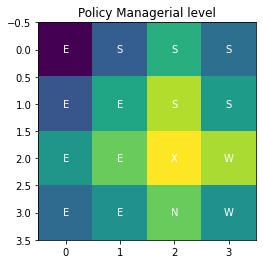

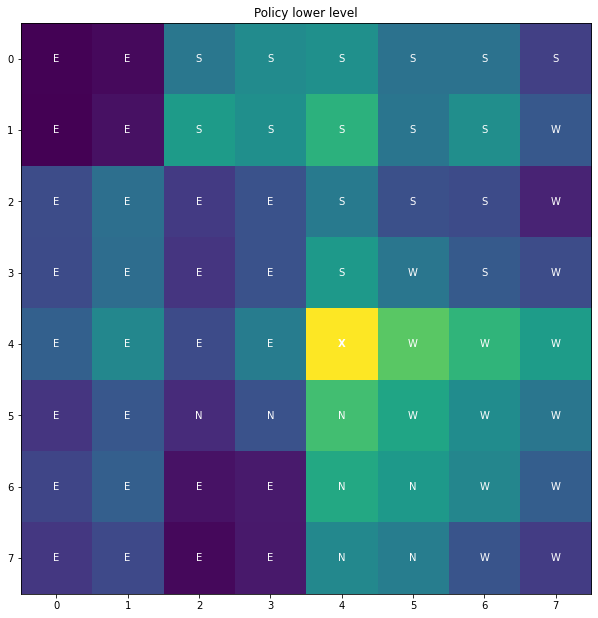

cccc
Nil
Parameter containing:
tensor([[1., 1., 1.]]) Parameter containing:
tensor([0.])
[1.0, 1.0, 1.0]
Ratio M/L: 1.0
[['S' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'N']]
[[list([(0, -12.517508506774902), (1, -6.3717427253723145), (2, -6.440860748291016), (3, -12.195104598999023)])
  list([(0, -13.283459663391113), (1, -5.615187168121338), (2, -6.217203617095947), (3, -10.23249626159668)])
  list([(0, -11.329232215881348), (1, -3.675826072692871), (2, -8.769333839416504), (3, -8.858981132507324)])
  list([(0, -12.939501762390137), (1, -5.625051021575928), (2, -11.2041654586792), (3, -8.553709030151367)])]
 [list([(0, -10.537527084350586), (1, -6.629903316497803), (2, -5.309799671173096), (3, -12.480448722839355)])
  list([(0, -9.003125190734863), (1, -4.19851541519165), (2, -3.2802574634552), (3, -7.731223106384277)])
  list([(0, -5.856622695922852), (1, -1.1297590732574463), (2, -6.44138765335083), (3, -4.761230945587158)])
  list([(0, -9.256190299987793

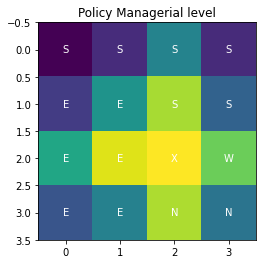

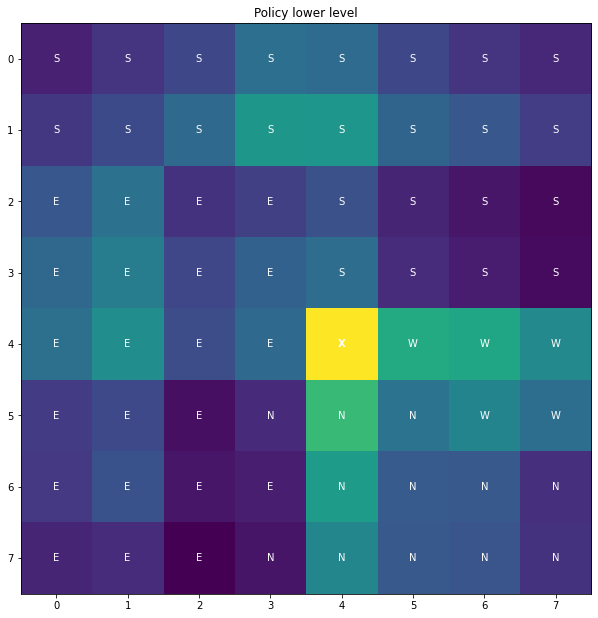

cccc
Exact
Parameter containing:
tensor([[1., 2., 4.]]) Parameter containing:
tensor([0.])
[1.0, 2.0, 4.0]
Ratio M/L: 2.0
[['E' 'S' 'S' 'S']
 ['E' 'S' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'W']]
[[list([(0, -12.836397171020508), (1, -6.870941162109375), (2, -6.288636684417725), (3, -11.332611083984375)])
  list([(0, -12.747915267944336), (1, -4.234673500061035), (2, -7.068418025970459), (3, -8.29958438873291)])
  list([(0, -9.878676414489746), (1, -2.523324966430664), (2, -7.97245454788208), (3, -8.462174415588379)])
  list([(0, -11.932780265808105), (1, -5.634003162384033), (2, -9.814757347106934), (3, -6.547084331512451)])]
 [list([(0, -8.85178279876709), (1, -6.805959701538086), (2, -3.948906898498535), (3, -11.049760818481445)])
  list([(0, -5.481823921203613), (1, -2.442155361175537), (2, -3.0678601264953613), (3, -6.057994842529297)])
  list([(0, -2.95904803276062), (1, -0.44310781359672546), (2, -5.1886305809021), (3, -5.2474822998046875)])
  list([(0, -7.66705036163330

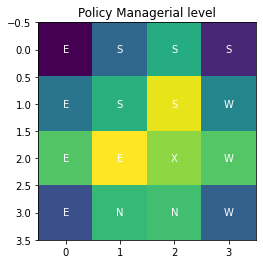

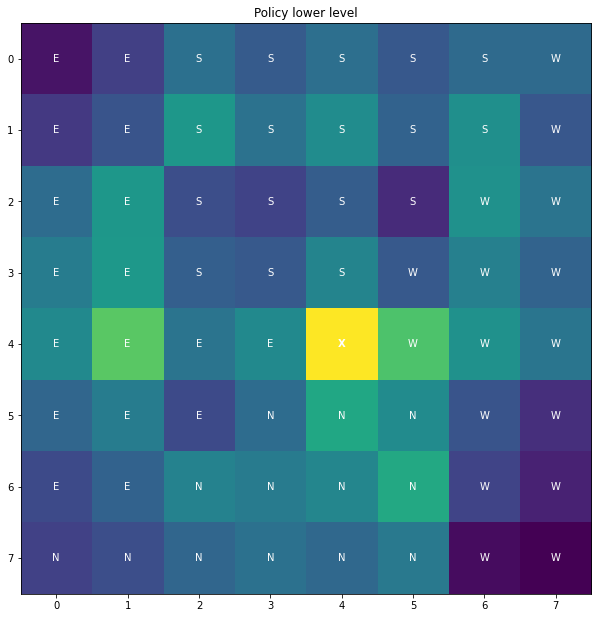

cccc
Learn
Parameter containing:
tensor([[-0.2421, -0.5425, -0.7106]], requires_grad=True) Parameter containing:
tensor([-0.3927], requires_grad=True)
[-0.6347904205322266, -0.93519127368927, -1.1033151149749756]
Ratio M/L: 1.1797748182812569
[['S' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'N']]
[[list([(0, -10.978555679321289), (1, -6.9453229904174805), (2, -7.097107887268066), (3, -12.313924789428711)])
  list([(0, -11.388147354125977), (1, -5.846330642700195), (2, -6.848161220550537), (3, -10.308463096618652)])
  list([(0, -9.274951934814453), (1, -3.2241833209991455), (2, -7.306848526000977), (3, -8.048213958740234)])
  list([(0, -10.234640121459961), (1, -4.731842041015625), (2, -8.513248443603516), (3, -7.666316509246826)])]
 [list([(0, -9.477684020996094), (1, -7.361271858215332), (2, -5.117975234985352), (3, -13.213415145874023)])
  list([(0, -7.851184844970703), (1, -4.4778900146484375), (2, -3.0478172302246094), (3, -9.08204460144043)])
  list([(0,

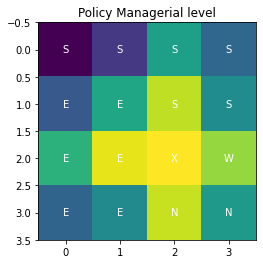

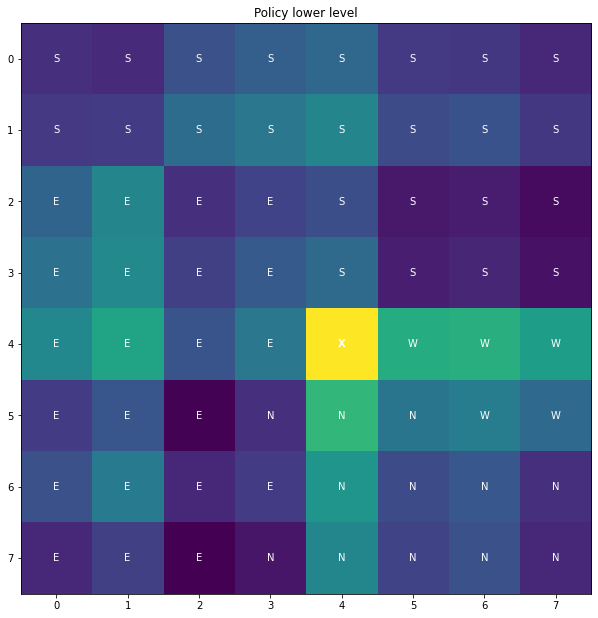

cccc
Init 4.95
Nil 5.04
Exact 4.9
Learn 5.17


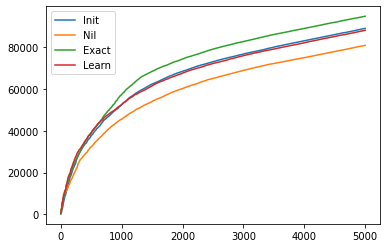

Init 4.95
Nil 5.04
Exact 4.9
Learn 5.17


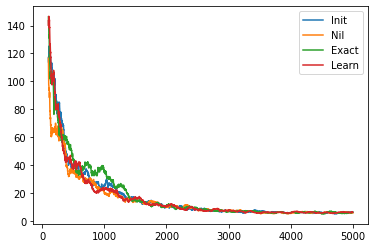

Init -29.85
Nil -31.47
Exact -27.06
Learn -33.03


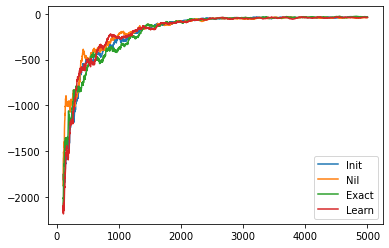

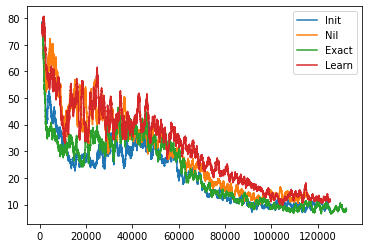

In [8]:
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    nn=r_dict_3[x]['Q_policy']
    out=[]
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print("=====================")
    print_policy(nn, env1, 0, 0)
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    
    print(labelp,pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_3[x]['episode_durations']).expanding().sum().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    
    print(labelp,pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    print(labelp,pd.Series(r_dict_3[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_3[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

Init 5.65
Nil 5.94
Exact 6.03
Learn 5.55


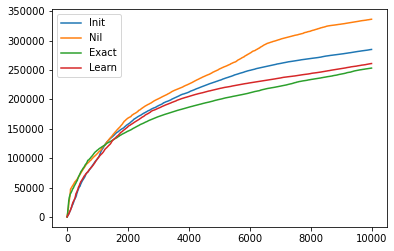

Init
Parameter containing:
tensor([[0.9389, 2.3584, 3.7395]], requires_grad=True) Parameter containing:
tensor([0.])
[0.9389350414276123, 2.3584370613098145, 3.7394800186157227]
Ratio M/L: 1.585575498266175
[['E' 'E' 'S' 'W']
 ['E' 'E' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'N']]
[[list([(0, -21.471080780029297), (1, -18.06894874572754), (2, -13.841917037963867), (3, -22.624088287353516)])
  list([(0, -20.422964096069336), (1, -14.603058815002441), (2, -11.009251594543457), (3, -18.632339477539062)])
  list([(0, -15.022868156433105), (1, -7.575713634490967), (2, -14.714487075805664), (3, -13.962329864501953)])
  list([(0, -19.055356979370117), (1, -16.13687515258789), (2, -18.95532989501953), (3, -12.260826110839844)])]
 [list([(0, -19.923492431640625), (1, -16.850406646728516), (2, -13.998303413391113), (3, -23.092742919921875)])
  list([(0, -17.39236831665039), (1, -11.38465404510498), (2, -9.82951545715332), (3, -18.093360900878906)])
  list([(0, -9.540032386779785), (1, -4.

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['E' 'E' 'E' 'E' 'S' 'S' 'W' 'W']
 ['N' 'MN' 'N' 'MN' 'S' 'MS' 'W' 'MW']
 ['E' 'E' 'ME' 'ME' 'S' 'S' 'MW' 'MW']
 ['N' 'MN' 'MN' 'ME' 'S' 'MS' 'MW' 'MW']
 ['E' 'E' 'E' 'E' 'X' 'MW' 'MW' 'MW']
 ['N' 'ME' 'N' 'MN' 'MN' 'MW' 'MW' 'MW']
 ['E' 'E' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN']
 ['N' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN']]
xxx


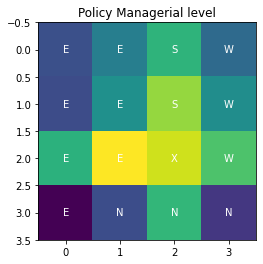

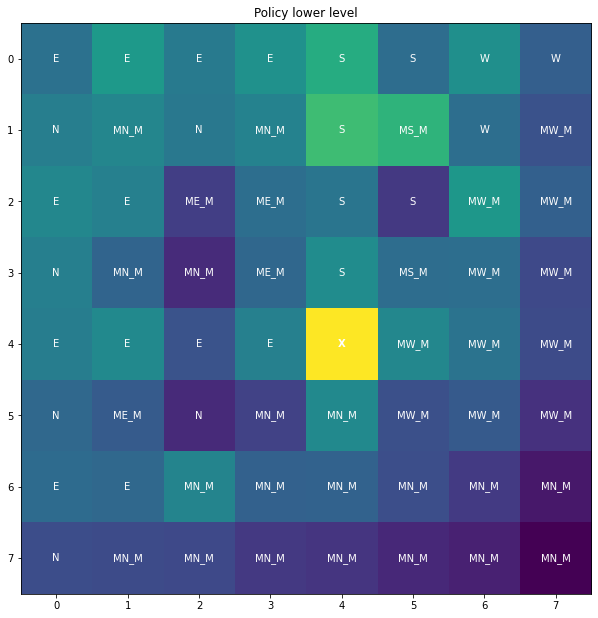

cccc
Nil
Parameter containing:
tensor([[1., 1., 1.]]) Parameter containing:
tensor([0.])
[1.0, 1.0, 1.0]
Ratio M/L: 1.0
[['E' 'E' 'S' 'S']
 ['E' 'E' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['N' 'N' 'N' 'N']]
[[list([(0, -22.00543975830078), (1, -14.595586776733398), (2, -14.27011775970459), (3, -21.62575912475586)])
  list([(0, -22.826141357421875), (1, -13.412294387817383), (2, -12.723869323730469), (3, -19.436622619628906)])
  list([(0, -18.12249183654785), (1, -6.741004943847656), (2, -15.31215763092041), (3, -15.511610984802246)])
  list([(0, -22.20077896118164), (1, -14.458754539489746), (2, -16.943374633789062), (3, -15.379029273986816)])]
 [list([(0, -20.5313663482666), (1, -13.912752151489258), (2, -13.693757057189941), (3, -22.728208541870117)])
  list([(0, -20.31114959716797), (1, -9.946773529052734), (2, -9.85952091217041), (3, -17.958614349365234)])
  list([(0, -12.508428573608398), (1, -2.5713553428649902), (2, -13.629131317138672), (3, -12.182193756103516)])
  list([(0, -18.051

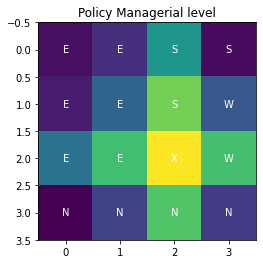

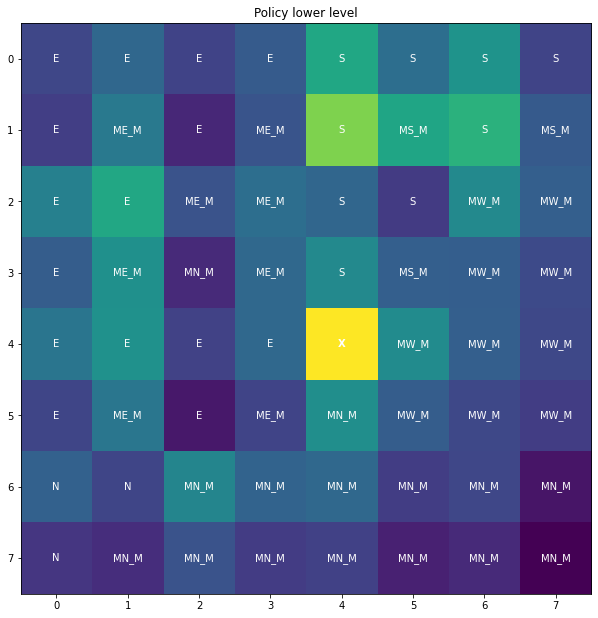

cccc
Exact
Parameter containing:
tensor([[1., 2., 4.]]) Parameter containing:
tensor([0.])
[1.0, 2.0, 4.0]
Ratio M/L: 2.0
[['S' 'S' 'S' 'W']
 ['S' 'S' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['N' 'N' 'N' 'N']]
[[list([(0, -19.299095153808594), (1, -10.357504844665527), (2, -13.5001859664917), (3, -16.095233917236328)])
  list([(0, -19.024580001831055), (1, -9.727152824401855), (2, -12.711441040039062), (3, -14.80980396270752)])
  list([(0, -15.396452903747559), (1, -6.245853900909424), (2, -14.657980918884277), (3, -12.738205909729004)])
  list([(0, -18.826814651489258), (1, -13.364020347595215), (2, -18.52794075012207), (3, -12.84630298614502)])]
 [list([(0, -14.555459022521973), (1, -7.921978950500488), (2, -11.032111167907715), (3, -15.587963104248047)])
  list([(0, -13.017008781433105), (1, -6.170714378356934), (2, -8.468896865844727), (3, -12.413490295410156)])
  list([(0, -7.358158111572266), (1, -2.3792803287506104), (2, -12.945293426513672), (3, -10.046796798706055)])
  list([(0, -14

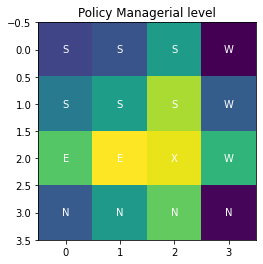

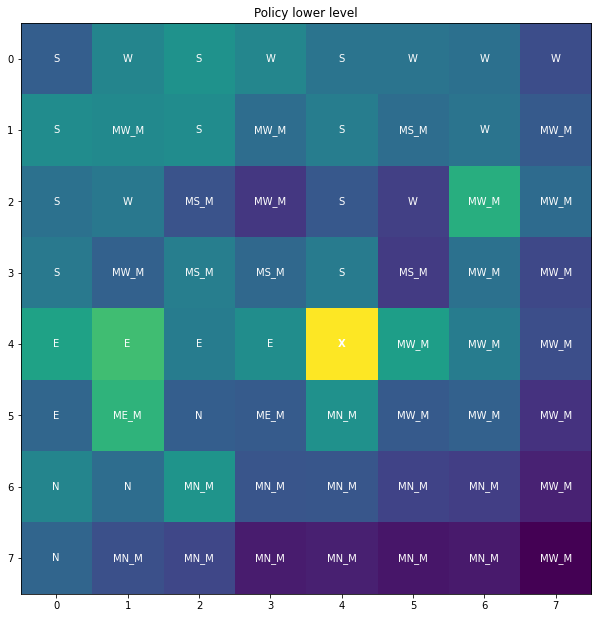

cccc
Learn
Parameter containing:
tensor([[-0.4867, -0.7651, -0.6825]], requires_grad=True) Parameter containing:
tensor([-0.0992], requires_grad=True)
[-0.5858110189437866, -0.8642672300338745, -0.7816310524940491]
Ratio M/L: 0.9043858488808068
[['E' 'E' 'S' 'S']
 ['E' 'E' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'W']]
[[list([(0, -21.02181053161621), (1, -15.376824378967285), (2, -14.08686351776123), (3, -22.172195434570312)])
  list([(0, -20.669322967529297), (1, -13.813790321350098), (2, -11.707825660705566), (3, -19.69574737548828)])
  list([(0, -16.506322860717773), (1, -6.906032562255859), (2, -15.98234748840332), (3, -15.212602615356445)])
  list([(0, -18.992021560668945), (1, -14.38386058807373), (2, -18.125722885131836), (3, -14.393270492553711)])]
 [list([(0, -19.526573181152344), (1, -14.135176658630371), (2, -13.236456871032715), (3, -22.820463180541992)])
  list([(0, -17.294740676879883), (1, -11.049777030944824), (2, -8.69610595703125), (3, -18.058143615722656)])
  

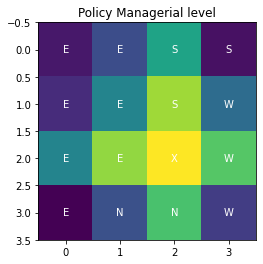

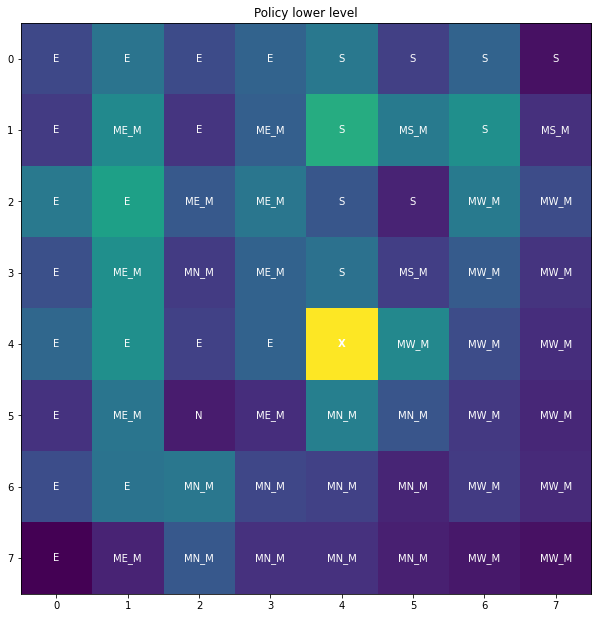

cccc
Init 5.75
Nil 5.05
Exact 5.39
Learn 5.08


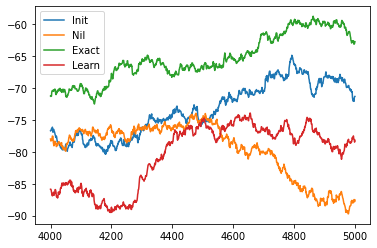

Init 5.75
Nil 5.05
Exact 5.39
Learn 5.08


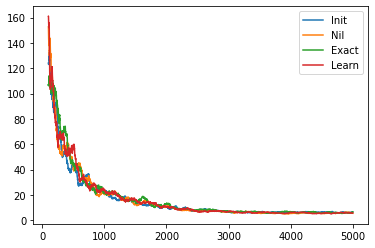

Init -61.65
Nil -69.33
Exact -52.95
Learn -62.42


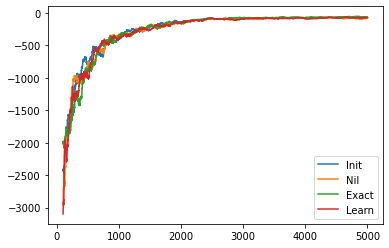

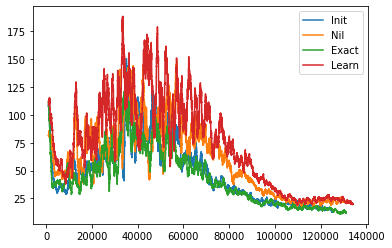

In [9]:
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    nn=r_dict_4[x]['Q_policy']
    out=[]
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print("=====================")
    print_policy(nn, env2, 0, 0)
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    
    print(labelp,pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_4[x]['rewards']).rolling(300).mean().tail(1000).plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    
    print(labelp,pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    print(labelp,pd.Series(r_dict_4[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_4[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    pd.Series(r_dict_4[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

Learn
Parameter containing:
tensor([[ 0.0245, -0.4919, -0.5263]], requires_grad=True) Parameter containing:
tensor([-0.3951], requires_grad=True)
[-0.370587557554245, -0.8870285749435425, -0.9214180707931519]
Ratio M/L: 1.0387693213285696
[['E' 'E' 'S' 'W']
 ['S' 'E' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'W']]
[[list([(0, -11.537233352661133), (1, -8.45387077331543), (2, -8.447295188903809), (3, -10.878975868225098)])
  list([(0, -11.225605964660645), (1, -7.725254535675049), (2, -7.043593883514404), (3, -10.236016273498535)])
  list([(0, -9.033761024475098), (1, -4.180875778198242), (2, -7.319728851318359), (3, -6.766438961029053)])
  list([(0, -10.031664848327637), (1, -6.464867115020752), (2, -7.457103729248047), (3, -6.290918827056885)])]
 [list([(0, -10.747997283935547), (1, -7.5047502517700195), (2, -7.554714679718018), (3, -10.952129364013672)])
  list([(0, -9.54201889038086), (1, -5.544343948364258), (2, -4.606756210327148), (3, -9.385354995727539)])
  list([(0, -6.045

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


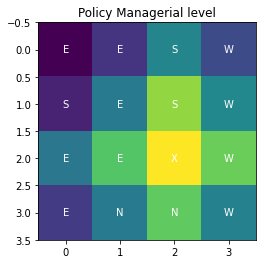

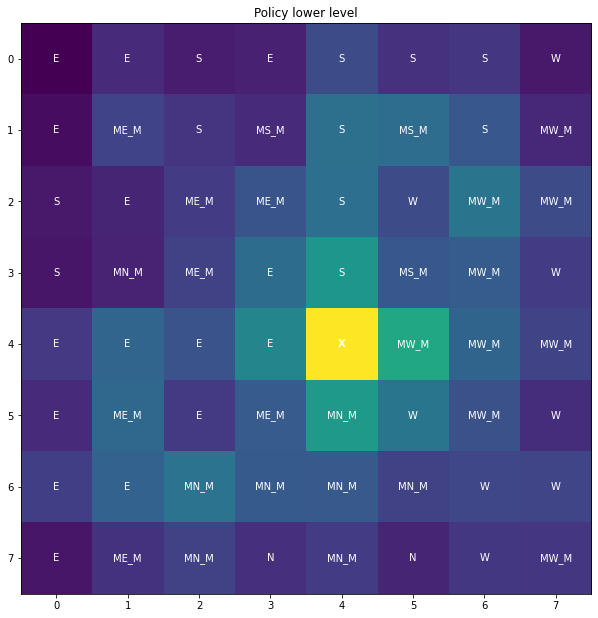

cccc
Init
Parameter containing:
tensor([[0.9658, 2.1515, 3.9104]], requires_grad=True) Parameter containing:
tensor([0.])
[0.9658219814300537, 2.1514928340911865, 3.9104132652282715]
Ratio M/L: 1.8175348777678229
[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['N' 'N' 'N' 'N']]
[[list([(0, -8.996905326843262), (1, -6.500353813171387), (2, -7.361482620239258), (3, -8.772698402404785)])
  list([(0, -8.79638957977295), (1, -5.802879333496094), (2, -6.335411548614502), (3, -8.187369346618652)])
  list([(0, -7.784743309020996), (1, -3.312458038330078), (2, -7.621668815612793), (3, -6.660317897796631)])
  list([(0, -8.157238960266113), (1, -6.260064601898193), (2, -7.585979461669922), (3, -6.470839977264404)])]
 [list([(0, -8.641644477844238), (1, -4.89762544631958), (2, -6.450229644775391), (3, -8.668097496032715)])
  list([(0, -7.796977519989014), (1, -2.4204635620117188), (2, -4.354974269866943), (3, -7.345118045806885)])
  list([(0, -5.742456912994385), (1, -0.00620342791

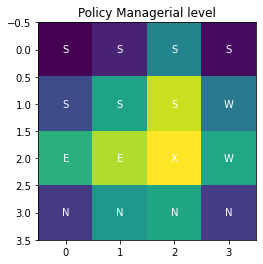

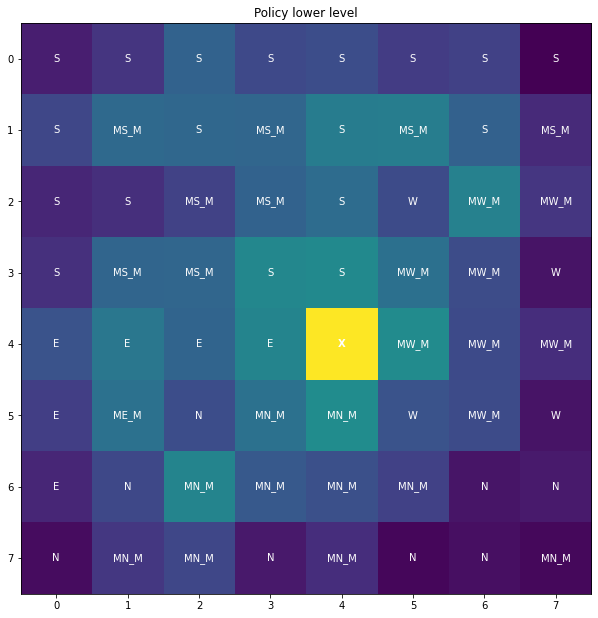

cccc
Nil
Parameter containing:
tensor([[1., 1., 1.]]) Parameter containing:
tensor([0.])
[1.0, 1.0, 1.0]
Ratio M/L: 1.0
[['E' 'S' 'S' 'S']
 ['S' 'S' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'N']]
[[list([(0, -11.4015474319458), (1, -7.730470657348633), (2, -7.700047016143799), (3, -11.611909866333008)])
  list([(0, -11.192058563232422), (1, -6.799912929534912), (2, -6.8118672370910645), (3, -11.089993476867676)])
  list([(0, -10.308070182800293), (1, -4.9198479652404785), (2, -8.871196746826172), (3, -8.377237319946289)])
  list([(0, -11.509864807128906), (1, -7.704686641693115), (2, -9.803462028503418), (3, -8.366177558898926)])]
 [list([(0, -10.008081436157227), (1, -6.379661560058594), (2, -6.879800796508789), (3, -10.787397384643555)])
  list([(0, -9.382399559020996), (1, -4.0918498039245605), (2, -4.41527795791626), (3, -9.941755294799805)])
  list([(0, -7.735721111297607), (1, -2.0230283737182617), (2, -8.357693672180176), (3, -6.505560398101807)])
  list([(0, -8.3242969512

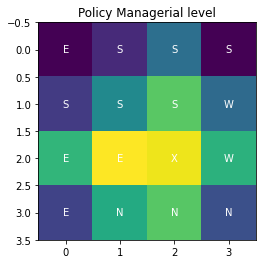

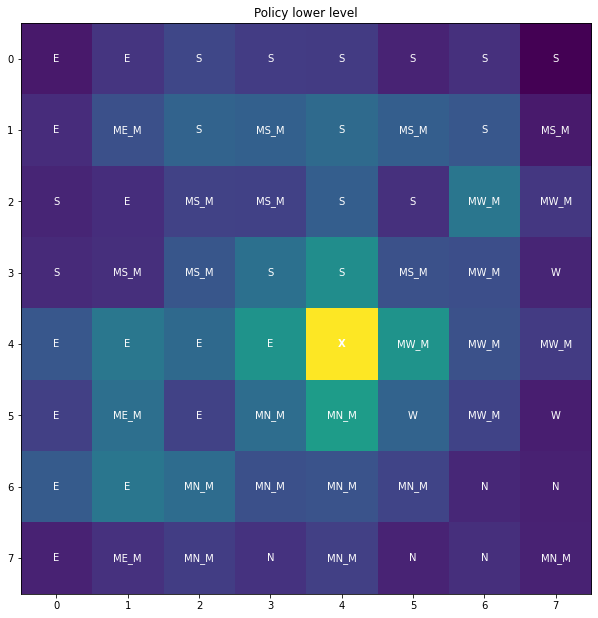

cccc
Exact
Parameter containing:
tensor([[1., 2., 4.]]) Parameter containing:
tensor([0.])
[1.0, 2.0, 4.0]
Ratio M/L: 2.0
[['E' 'S' 'S' 'W']
 ['S' 'S' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'W']]
[[list([(0, -9.715718269348145), (1, -7.570747375488281), (2, -7.422351837158203), (3, -8.989277839660645)])
  list([(0, -9.122785568237305), (1, -6.744060039520264), (2, -6.975924491882324), (3, -8.324638366699219)])
  list([(0, -7.495802402496338), (1, -3.9258599281311035), (2, -8.46146297454834), (3, -6.9893693923950195)])
  list([(0, -8.463249206542969), (1, -6.844724178314209), (2, -7.33732795715332), (3, -6.630032539367676)])]
 [list([(0, -8.22176742553711), (1, -6.293920516967773), (2, -7.022764205932617), (3, -8.516019821166992)])
  list([(0, -6.973047256469727), (1, -3.3488402366638184), (2, -5.585221767425537), (3, -7.131206512451172)])
  list([(0, -5.055678844451904), (1, -0.3804311156272888), (2, -8.370978355407715), (3, -5.489686965942383)])
  list([(0, -5.347592830657959)

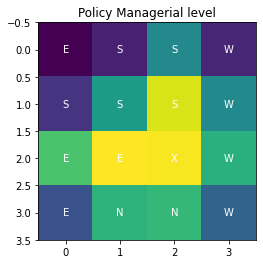

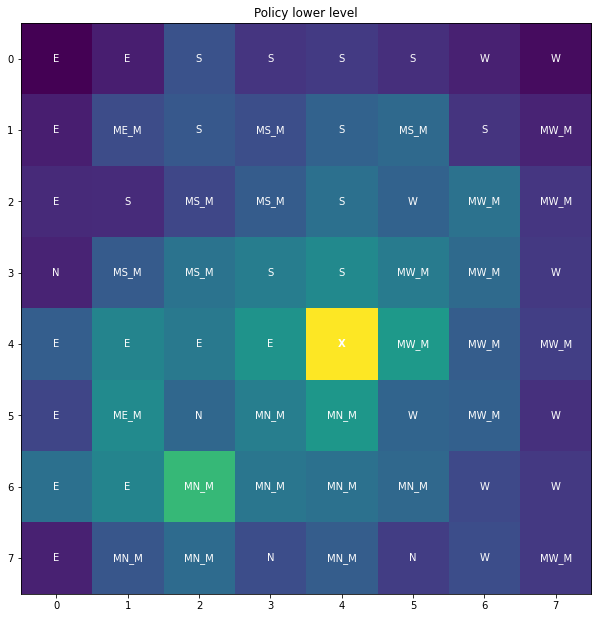

cccc
Learn 4.2
Init 4.5
Nil 4.51
Exact 4.38


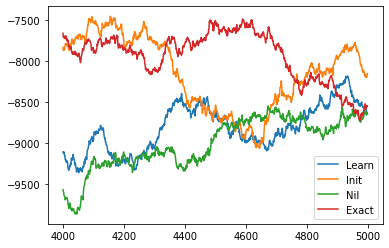

Learn 4.2
Init 4.5
Nil 4.51
Exact 4.38


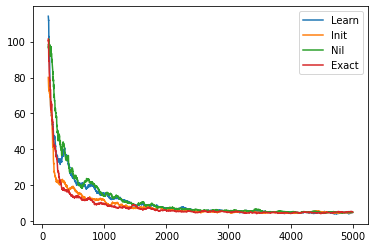

Learn -24.33
Init -23.52
Nil -26.11
Exact -22.65


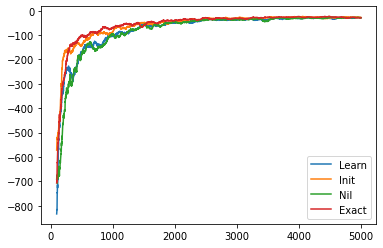

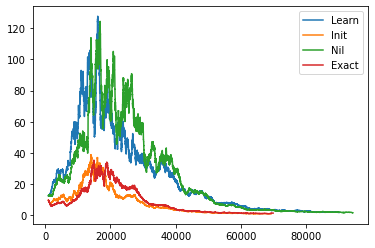

In [9]:
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    nn=r_dict_5[x]['Q_policy']
    out=[]
    
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print_policy(nn, env3, 0, 0)
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    
    print(labelp,pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_5[x]['rewards']).rolling(300).sum().tail(1000).plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    
    print(labelp,pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    print(labelp,pd.Series(r_dict_5[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_5[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    pd.Series(r_dict_5[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

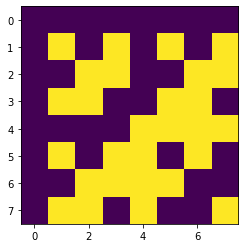

In [11]:
plt.imshow(env3.maze)

In [12]:
env3.goal_init_state

[4, 4]

[3, 0]
[[0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


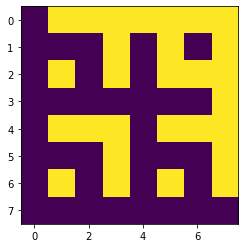

In [20]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(8
                        , 2, 2, 3, False,False,2,True,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]

r_dict_6={}

# resul6s = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 5000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cpu")
env4=copy.copy(env)

In [21]:


for man_init in ['Learn','Init','Nil','Exact']:
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
            clear_output(wait=True)
            print(man_init)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_6[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

Exact


  0%|                                                                               | 1/5000 [00:05<7:22:03,  5.31s/it]

epsilon 0.7844266666666667


  0%|▏                                                                             | 13/5000 [00:44<4:24:28,  3.18s/it]

x


  1%|▊                                                                             | 51/5000 [02:11<1:42:49,  1.25s/it]

epsilon 0.7365


  2%|█▌                                                                           | 101/5000 [03:20<2:53:12,  2.12s/it]

epsilon 0.723


  3%|██▎                                                                          | 151/5000 [05:15<1:06:55,  1.21it/s]

epsilon 0.7095


  4%|██▊                                                                          | 185/5000 [06:33<2:54:11,  2.17s/it]

x


  4%|███                                                                          | 201/5000 [07:07<2:20:45,  1.76s/it]

epsilon 0.696


  5%|███▋                                                                         | 243/5000 [08:29<1:32:49,  1.17s/it]

x


  5%|███▉                                                                           | 251/5000 [08:35<54:12,  1.46it/s]

epsilon 0.6825


  6%|████▊                                                                          | 302/5000 [09:19<51:48,  1.51it/s]

epsilon 0.669


  6%|████▊                                                                        | 309/5000 [09:27<1:01:47,  1.27it/s]

x


  7%|█████▏                                                                         | 328/5000 [09:46<48:17,  1.61it/s]

x


  7%|█████▏                                                                       | 333/5000 [09:50<1:11:17,  1.09it/s]

x


  7%|█████▍                                                                       | 351/5000 [10:14<2:31:53,  1.96s/it]

epsilon 0.6555
[92.79666666666667]
min mean 92.79666666666667
last mean 350    94.44
dtype: float64


  8%|██████▎                                                                        | 401/5000 [11:14<43:07,  1.78it/s]

epsilon 0.642
[92.79666666666667, 90.92]
min mean 90.92
last mean 400    93.57
dtype: float64


  9%|██████▊                                                                        | 428/5000 [11:38<44:19,  1.72it/s]

x


  9%|███████▏                                                                       | 451/5000 [11:56<53:07,  1.43it/s]

epsilon 0.6285000000000001
[92.79666666666667, 90.92, 78.42333333333333]
min mean 78.42333333333333
last mean 450    78.953333
dtype: float64


 10%|███████▉                                                                       | 501/5000 [12:25<30:04,  2.49it/s]

epsilon 0.615
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334]
min mean 63.36333333333334
last mean 500    63.363333
dtype: float64


 11%|████████▋                                                                      | 551/5000 [13:03<50:27,  1.47it/s]

epsilon 0.6014999999999999
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62]
min mean 54.62
last mean 550    54.756667
dtype: float64


 12%|█████████▎                                                                   | 601/5000 [13:35<1:12:23,  1.01it/s]

epsilon 0.588
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0]
min mean 52.0
last mean 600    52.336667
dtype: float64


 13%|█████████▉                                                                   | 642/5000 [14:08<1:00:08,  1.21it/s]

x


 13%|██████████▎                                                                    | 651/5000 [14:14<31:17,  2.32it/s]

epsilon 0.5745
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334]
min mean 49.163333333333334
last mean 650    49.163333
dtype: float64


 13%|██████████▍                                                                    | 663/5000 [14:20<34:22,  2.10it/s]

x


 14%|██████████▊                                                                    | 682/5000 [14:33<50:02,  1.44it/s]

x


 14%|███████████                                                                    | 701/5000 [14:41<36:37,  1.96it/s]

epsilon 0.5609999999999999
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667]
min mean 42.71666666666667
last mean 700    42.93
dtype: float64


 14%|███████████▍                                                                   | 723/5000 [14:55<39:10,  1.82it/s]

x


 15%|███████████▊                                                                   | 751/5000 [15:11<51:42,  1.37it/s]

epsilon 0.5475
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68]
min mean 40.68
last mean 750    40.906667
dtype: float64


 16%|████████████▎                                                                | 800/5000 [15:42<1:09:25,  1.01it/s]

epsilon 0.534
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68]
min mean 40.68
last mean 800    41.773333
dtype: float64


 17%|█████████████▍                                                                 | 850/5000 [16:09<36:53,  1.87it/s]

x


 17%|█████████████▍                                                                 | 851/5000 [16:10<45:17,  1.53it/s]

epsilon 0.5205
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667]
min mean 39.61666666666667
last mean 850    40.206667
dtype: float64


 18%|██████████████▏                                                                | 901/5000 [16:36<52:17,  1.31it/s]

epsilon 0.507
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333]
min mean 37.82333333333333
last mean 900    38.79
dtype: float64


 19%|██████████████▋                                                              | 951/5000 [17:11<1:51:08,  1.65s/it]

epsilon 0.4935
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334]
min mean 35.233333333333334
last mean 950    36.39
dtype: float64


 19%|██████████████▊                                                              | 958/5000 [17:18<1:26:45,  1.29s/it]

x


 19%|███████████████▍                                                               | 974/5000 [17:32<53:52,  1.25it/s]

x


 20%|███████████████▌                                                              | 1001/5000 [17:47<49:24,  1.35it/s]

epsilon 0.48
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1000    36.993333
dtype: float64


 21%|████████████████▍                                                             | 1051/5000 [18:29<47:39,  1.38it/s]

epsilon 0.4665
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1050    38.016667
dtype: float64


 21%|████████████████                                                            | 1056/5000 [18:36<1:23:17,  1.27s/it]

x


 22%|████████████████▋                                                           | 1101/5000 [19:18<1:10:00,  1.08s/it]

epsilon 0.45299999999999996
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1100    40.61
dtype: float64


 23%|█████████████████▊                                                            | 1142/5000 [19:45<43:18,  1.48it/s]

x


 23%|█████████████████▉                                                            | 1151/5000 [19:47<15:30,  4.13it/s]

epsilon 0.4395
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1150    40.166667
dtype: float64


 23%|█████████████████▉                                                            | 1152/5000 [19:49<38:21,  1.67it/s]

x


 24%|██████████████████▍                                                           | 1182/5000 [20:13<49:35,  1.28it/s]

x


 24%|██████████████████▋                                                           | 1201/5000 [20:23<19:03,  3.32it/s]

epsilon 0.426
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1200    41.36
dtype: float64


 25%|███████████████████▏                                                          | 1233/5000 [20:39<27:27,  2.29it/s]

x


 25%|███████████████████                                                         | 1251/5000 [20:50<1:02:55,  1.01s/it]

epsilon 0.4125
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1250    40.336667
dtype: float64


 26%|███████████████████▋                                                        | 1293/5000 [21:26<1:49:48,  1.78s/it]

x


 26%|████████████████████▎                                                         | 1301/5000 [21:29<34:12,  1.80it/s]

epsilon 0.39899999999999997
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1300    40.976667
dtype: float64


 27%|█████████████████████                                                         | 1351/5000 [21:50<30:39,  1.98it/s]

epsilon 0.3855
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334]
min mean 35.233333333333334
last mean 1350    37.346667
dtype: float64


 28%|█████████████████████▊                                                        | 1401/5000 [22:11<28:21,  2.11it/s]

epsilon 0.372
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5]
min mean 31.5
last mean 1400    31.516667
dtype: float64


 29%|██████████████████████▋                                                       | 1451/5000 [22:32<23:22,  2.53it/s]

epsilon 0.3585
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34]
min mean 29.34
last mean 1450    29.763333
dtype: float64


 30%|███████████████████████▍                                                      | 1501/5000 [22:46<14:01,  4.16it/s]

epsilon 0.345
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667]
min mean 25.886666666666667
last mean 1500    25.886667
dtype: float64


 31%|████████████████████████▏                                                     | 1551/5000 [23:04<24:01,  2.39it/s]

epsilon 0.33149999999999996
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6]
min mean 24.6
last mean 1550    24.6
dtype: float64


 32%|████████████████████████▊                                                     | 1589/5000 [23:18<12:43,  4.47it/s]

x


 32%|████████████████████████▉                                                     | 1601/5000 [23:21<14:24,  3.93it/s]

epsilon 0.31800000000000006
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334]
min mean 20.733333333333334
last mean 1600    20.74
dtype: float64


 32%|█████████████████████████▏                                                    | 1611/5000 [23:25<26:26,  2.14it/s]

x


 33%|█████████████████████████▊                                                    | 1651/5000 [23:37<23:32,  2.37it/s]

epsilon 0.3045
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666]
min mean 20.016666666666666
last mean 1650    20.066667
dtype: float64


 33%|██████████████████████████                                                    | 1667/5000 [23:41<14:02,  3.96it/s]

x


 34%|██████████████████████████▎                                                   | 1683/5000 [23:46<16:34,  3.33it/s]

x


 34%|██████████████████████████▌                                                   | 1700/5000 [23:51<17:39,  3.12it/s]

epsilon 0.29100000000000004
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668]
min mean 18.986666666666668
last mean 1700    18.986667
dtype: float64


 35%|███████████████████████████▎                                                  | 1752/5000 [24:06<18:29,  2.93it/s]

epsilon 0.27749999999999997
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333]
min mean 17.60333333333333
last mean 1750    17.826667
dtype: float64


 36%|███████████████████████████▊                                                  | 1783/5000 [24:15<15:04,  3.56it/s]

x


 36%|███████████████████████████▉                                                  | 1792/5000 [24:17<10:57,  4.88it/s]

x


 36%|████████████████████████████                                                  | 1801/5000 [24:19<09:23,  5.67it/s]

epsilon 0.264
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332]
min mean 17.173333333333332
last mean 1800    17.486667
dtype: float64


 37%|████████████████████████████▉                                                 | 1851/5000 [24:30<14:24,  3.64it/s]

epsilon 0.25049999999999994
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86]
min mean 15.86
last mean 1850    15.863333
dtype: float64


 38%|█████████████████████████████▋                                                | 1902/5000 [24:42<12:42,  4.06it/s]

epsilon 0.237
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666]
min mean 14.676666666666666
last mean 1900    14.813333
dtype: float64


 39%|██████████████████████████████▍                                               | 1951/5000 [24:53<12:06,  4.20it/s]

epsilon 0.22350000000000003
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334]
min mean 13.843333333333334
last mean 1950    13.856667
dtype: float64


 40%|███████████████████████████████▏                                              | 2002/5000 [25:05<11:29,  4.35it/s]

epsilon 0.20999999999999996
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2]
min mean 13.2
last mean 2000    13.57
dtype: float64


 41%|████████████████████████████████                                              | 2053/5000 [25:16<08:16,  5.93it/s]

epsilon 0.1965
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667]
min mean 12.766666666666667
last mean 2050    12.776667
dtype: float64


 42%|████████████████████████████████▊                                             | 2101/5000 [25:26<08:22,  5.77it/s]

epsilon 0.18300000000000005
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334]
min mean 12.183333333333334
last mean 2100    12.21
dtype: float64


 43%|█████████████████████████████████▌                                            | 2151/5000 [25:35<10:40,  4.45it/s]

epsilon 0.16949999999999998
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333]
min mean 11.773333333333333
last mean 2150    11.773333
dtype: float64


 44%|██████████████████████████████████▎                                           | 2201/5000 [25:43<07:32,  6.19it/s]

epsilon 0.15599999999999992
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666]
min mean 11.066666666666666
last mean 2200    11.066667
dtype: float64


 45%|███████████████████████████████████                                           | 2251/5000 [25:51<08:15,  5.55it/s]

epsilon 0.14249999999999996
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666]
min mean 10.246666666666666
last mean 2250    10.246667
dtype: float64


 46%|███████████████████████████████████▉                                          | 2301/5000 [26:00<09:09,  4.91it/s]

epsilon 0.129
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667]
min mean 9.366666666666667
last mean 2300    9.366667
dtype: float64


 47%|████████████████████████████████████▋                                         | 2351/5000 [26:09<10:09,  4.35it/s]

epsilon 0.11550000000000005
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77]
min mean 8.77
last mean 2350    8.843333
dtype: float64


 48%|█████████████████████████████████████▍                                        | 2402/5000 [26:19<07:05,  6.10it/s]

epsilon 0.10199999999999998
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42]
min mean 8.42
last mean 2400    8.433333
dtype: float64


 49%|██████████████████████████████████████▎                                       | 2453/5000 [26:26<06:21,  6.67it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667]
min mean 8.046666666666667
last mean 2450    8.063333
dtype: float64


 50%|███████████████████████████████████████                                       | 2501/5000 [26:35<07:37,  5.47it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334]
min mean 7.843333333333334
last mean 2500    7.98
dtype: float64


 51%|███████████████████████████████████████▊                                      | 2552/5000 [26:44<09:08,  4.47it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335]
min mean 7.8133333333333335
last mean 2550    8.043333
dtype: float64


 52%|████████████████████████████████████████▌                                     | 2601/5000 [26:52<06:33,  6.10it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335]
min mean 7.8133333333333335
last mean 2600    7.913333
dtype: float64


 53%|█████████████████████████████████████████▎                                    | 2651/5000 [27:00<07:38,  5.12it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55]
min mean 7.55
last mean 2650    7.55
dtype: float64


 54%|██████████████████████████████████████████▏                                   | 2701/5000 [27:08<05:37,  6.80it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46]
min mean 7.46
last mean 2700    7.623333
dtype: float64


 55%|██████████████████████████████████████████▉                                   | 2750/5000 [27:16<06:15,  5.99it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46]
min mean 7.46
last mean 2750    7.636667
dtype: float64


 56%|███████████████████████████████████████████▋                                  | 2802/5000 [27:23<05:49,  6.28it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333]
min mean 7.423333333333333
last mean 2800    7.49
dtype: float64


 57%|████████████████████████████████████████████▍                                 | 2851/5000 [27:32<10:02,  3.57it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39]
min mean 7.39
last mean 2850    7.393333
dtype: float64


 58%|█████████████████████████████████████████████▎                                | 2901/5000 [27:42<05:09,  6.78it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19]
min mean 7.19
last mean 2900    7.39
dtype: float64


 59%|██████████████████████████████████████████████                                | 2952/5000 [27:49<05:35,  6.11it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19]
min mean 7.19
last mean 2950    7.47
dtype: float64


 60%|██████████████████████████████████████████████▍                               | 2977/5000 [27:53<05:11,  6.49it/s]

x


 60%|██████████████████████████████████████████████▊                               | 3001/5000 [27:57<06:29,  5.14it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19]
min mean 7.19
last mean 3000    7.553333
dtype: float64


 61%|███████████████████████████████████████████████▌                              | 3051/5000 [28:05<04:21,  7.46it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19]
min mean 7.19
last mean 3050    7.633333
dtype: float64


 61%|███████████████████████████████████████████████▋                              | 3060/5000 [28:06<05:22,  6.02it/s]

x


 62%|████████████████████████████████████████████████▍                             | 3102/5000 [28:12<04:30,  7.02it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19]
min mean 7.19
last mean 3100    7.626667
dtype: float64


 63%|█████████████████████████████████████████████████▏                            | 3151/5000 [28:19<05:44,  5.37it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19]
min mean 7.19
last mean 3150    7.39
dtype: float64


 64%|█████████████████████████████████████████████████▉                            | 3200/5000 [28:26<04:22,  6.86it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19]
min mean 7.19
last mean 3200    7.21
dtype: float64


 65%|██████████████████████████████████████████████████▋                           | 3252/5000 [28:33<03:13,  9.05it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333]
min mean 6.993333333333333
last mean 3250    6.993333
dtype: float64


 66%|███████████████████████████████████████████████████▍                          | 3301/5000 [28:41<04:15,  6.66it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333]
min mean 6.863333333333333
last mean 3300    6.863333
dtype: float64


 67%|████████████████████████████████████████████████████▎                         | 3353/5000 [28:50<06:12,  4.42it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71]
min mean 6.71
last mean 3350    6.956667
dtype: float64


 68%|████████████████████████████████████████████████████▉                         | 3394/5000 [28:56<04:07,  6.49it/s]

x


 68%|█████████████████████████████████████████████████████                         | 3401/5000 [28:57<04:04,  6.54it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665]
min mean 6.6466666666666665
last mean 3400    6.69
dtype: float64


 69%|█████████████████████████████████████████████████████▊                        | 3450/5000 [29:04<04:04,  6.33it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63]
min mean 6.63
last mean 3450    6.63
dtype: float64


 70%|██████████████████████████████████████████████████████▌                       | 3501/5000 [29:12<04:21,  5.72it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333]
min mean 6.573333333333333
last mean 3500    6.636667
dtype: floa

 71%|███████████████████████████████████████████████████████▍                      | 3552/5000 [29:20<04:13,  5.72it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667]
min mean 6.516666666666667
last mean 3550    6

 72%|████████████████████████████████████████████████████████▏                     | 3601/5000 [29:27<03:22,  6.91it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42]
min mean 6.42
last mean 3600    6.46
dty

 73%|████████████████████████████████████████████████████████▉                     | 3651/5000 [29:36<07:03,  3.18it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24]
min mean 6.24
last mean 3650    6.

 74%|█████████████████████████████████████████████████████████▊                    | 3702/5000 [29:46<03:41,  5.87it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24]
min mean 6.24
last mean 3700

 75%|██████████████████████████████████████████████████████████▌                   | 3752/5000 [29:53<02:41,  7.73it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24]
min mean 6.24
last mea

 76%|███████████████████████████████████████████████████████████▎                  | 3801/5000 [30:00<03:14,  6.16it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24]
min mean 6.24
la

 77%|████████████████████████████████████████████████████████████                  | 3851/5000 [30:08<02:27,  7.77it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24]
min mean 6

 78%|████████████████████████████████████████████████████████████▊                 | 3902/5000 [30:16<02:44,  6.66it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 79%|█████████████████████████████████████████████████████████████▋                | 3951/5000 [30:23<02:56,  5.96it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 80%|██████████████████████████████████████████████████████████████▍               | 4002/5000 [30:30<02:40,  6.23it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 81%|███████████████████████████████████████████████████████████████▏              | 4051/5000 [30:40<04:18,  3.67it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 82%|███████████████████████████████████████████████████████████████▉              | 4101/5000 [30:48<02:22,  6.33it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 83%|████████████████████████████████████████████████████████████████▊             | 4152/5000 [30:56<02:27,  5.75it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 84%|█████████████████████████████████████████████████████████████████▌            | 4201/5000 [31:04<02:13,  5.97it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 85%|██████████████████████████████████████████████████████████████████▎           | 4252/5000 [31:12<01:57,  6.36it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 86%|███████████████████████████████████████████████████████████████████           | 4301/5000 [31:19<01:40,  6.93it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 87%|███████████████████████████████████████████████████████████████████▉          | 4351/5000 [31:27<02:06,  5.13it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 88%|████████████████████████████████████████████████████████████████████▋         | 4402/5000 [31:35<01:40,  5.93it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 89%|█████████████████████████████████████████████████████████████████████▍        | 4451/5000 [31:43<01:49,  5.02it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 90%|██████████████████████████████████████████████████████████████████████▏       | 4501/5000 [31:50<01:23,  5.96it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 91%|██████████████████████████████████████████████████████████████████████▉       | 4551/5000 [32:00<01:35,  4.69it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 92%|███████████████████████████████████████████████████████████████████████▊      | 4601/5000 [32:09<01:49,  3.64it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 92%|████████████████████████████████████████████████████████████████████████      | 4619/5000 [32:12<01:13,  5.18it/s]

x


 93%|████████████████████████████████████████████████████████████████████████▌     | 4652/5000 [32:18<00:56,  6.19it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4701/5000 [32:27<01:02,  4.81it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 95%|██████████████████████████████████████████████████████████████████████████    | 4751/5000 [32:36<00:53,  4.70it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4801/5000 [32:44<00:38,  5.18it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4851/5000 [32:52<00:24,  6.04it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4901/5000 [33:03<00:26,  3.68it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

 99%|█████████████████████████████████████████████████████████████████████████████▎| 4952/5000 [33:13<00:07,  6.34it/s]

epsilon 0.1
[92.79666666666667, 90.92, 78.42333333333333, 63.36333333333334, 54.62, 52.0, 49.163333333333334, 42.71666666666667, 40.68, 40.68, 39.61666666666667, 37.82333333333333, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 35.233333333333334, 31.5, 29.34, 25.886666666666667, 24.6, 20.733333333333334, 20.016666666666666, 18.986666666666668, 17.60333333333333, 17.173333333333332, 15.86, 14.676666666666666, 13.843333333333334, 13.2, 12.766666666666667, 12.183333333333334, 11.773333333333333, 11.066666666666666, 10.246666666666666, 9.366666666666667, 8.77, 8.42, 8.046666666666667, 7.843333333333334, 7.8133333333333335, 7.8133333333333335, 7.55, 7.46, 7.46, 7.423333333333333, 7.39, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 7.19, 6.993333333333333, 6.863333333333333, 6.71, 6.6466666666666665, 6.63, 6.573333333333333, 6.516666666666667, 6.42, 6.24, 6.24, 6.24, 6.24, 6.24, 6.18666666

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [33:22<00:00,  2.50it/s]


Learn
Parameter containing:
tensor([[ 0.0233, -0.4108, -0.7310]], requires_grad=True) Parameter containing:
tensor([-0.5546], requires_grad=True)
[-0.5312612056732178, -0.9654222130775452, -1.2855589389801025]
Ratio M/L: 1.3316028174678463
[['E' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -20.93901824951172), (1, -13.185060501098633), (2, -13.043227195739746), (3, -20.025968551635742)])
  list([(0, -24.423751831054688), (1, -13.190817832946777), (2, -14.102980613708496), (3, -14.340689659118652)])
  list([(0, -18.38460922241211), (1, -7.595243453979492), (2, -12.587235450744629), (3, -15.0552339553833)])
  list([(0, -19.133678436279297), (1, -9.160857200622559), (2, -12.585050582885742), (3, -11.211342811584473)])]
 [list([(0, -12.869223594665527), (1, -12.964492797851562), (2, -10.46147632598877), (3, -22.024274826049805)])
  list([(0, -13.567352294921875), (1, -12.124242782592773), (2, -10.376357078552246), (3, -14.865314483642578)])
  list

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



xxx


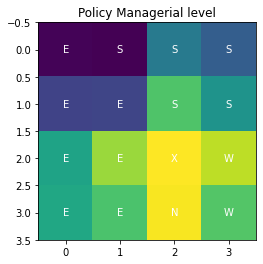

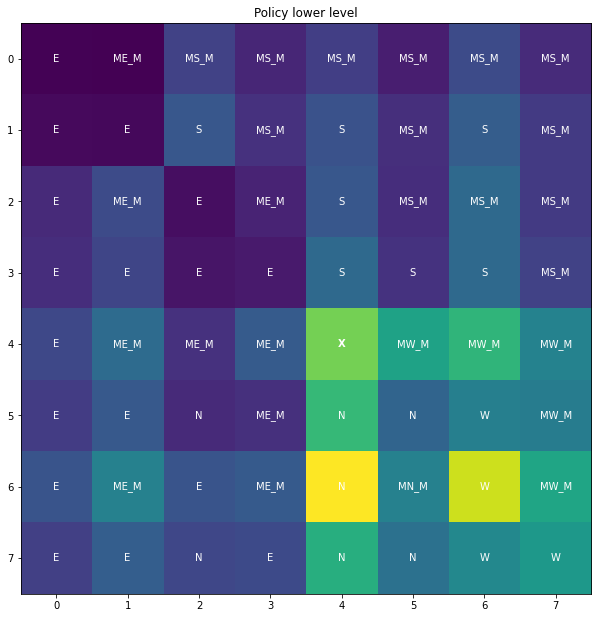

cccc
Init
Parameter containing:
tensor([[0.9295, 1.9911, 4.1347]], requires_grad=True) Parameter containing:
tensor([0.])
[0.9294829368591309, 1.9911009073257446, 4.134709358215332]
Ratio M/L: 2.076594582927832
[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -20.916336059570312), (1, -9.848602294921875), (2, -15.222243309020996), (3, -18.810914993286133)])
  list([(0, -22.801265716552734), (1, -10.766159057617188), (2, -16.089061737060547), (3, -16.48604393005371)])
  list([(0, -18.313819885253906), (1, -8.219298362731934), (2, -13.400666236877441), (3, -18.33332061767578)])
  list([(0, -20.763872146606445), (1, -10.601542472839355), (2, -16.046079635620117), (3, -16.349830627441406)])]
 [list([(0, -15.35989761352539), (1, -9.496475219726562), (2, -12.114876747131348), (3, -18.80821418762207)])
  list([(0, -14.005050659179688), (1, -9.29905891418457), (2, -11.7381591796875), (3, -13.487516403198242)])
  list([(0, -6.166957378387451), (1, -4

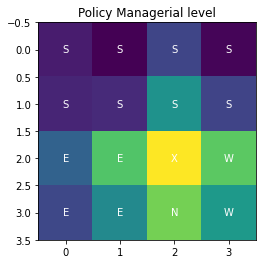

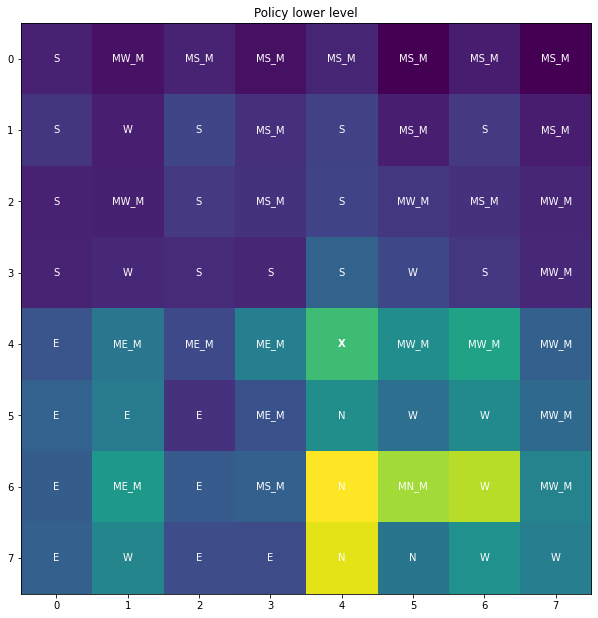

cccc
Nil
Parameter containing:
tensor([[1., 1., 1.]]) Parameter containing:
tensor([0.])
[1.0, 1.0, 1.0]
Ratio M/L: 1.0
[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -21.1901798248291), (1, -10.487678527832031), (2, -15.26687240600586), (3, -20.455202102661133)])
  list([(0, -24.566377639770508), (1, -10.742239952087402), (2, -17.980024337768555), (3, -15.305994033813477)])
  list([(0, -18.617143630981445), (1, -7.447366714477539), (2, -15.059622764587402), (3, -16.423864364624023)])
  list([(0, -20.665878295898438), (1, -8.378759384155273), (2, -17.254533767700195), (3, -11.284643173217773)])]
 [list([(0, -15.424158096313477), (1, -11.770614624023438), (2, -12.711006164550781), (3, -21.90553092956543)])
  list([(0, -18.185569763183594), (1, -10.429009437561035), (2, -14.786270141601562), (3, -13.782581329345703)])
  list([(0, -10.907965660095215), (1, -4.948206424713135), (2, -12.369028091430664), (3, -11.966609954833984)])
  list([(0, -

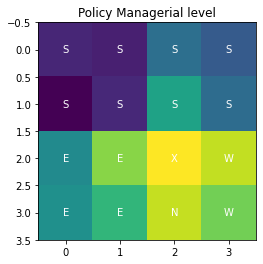

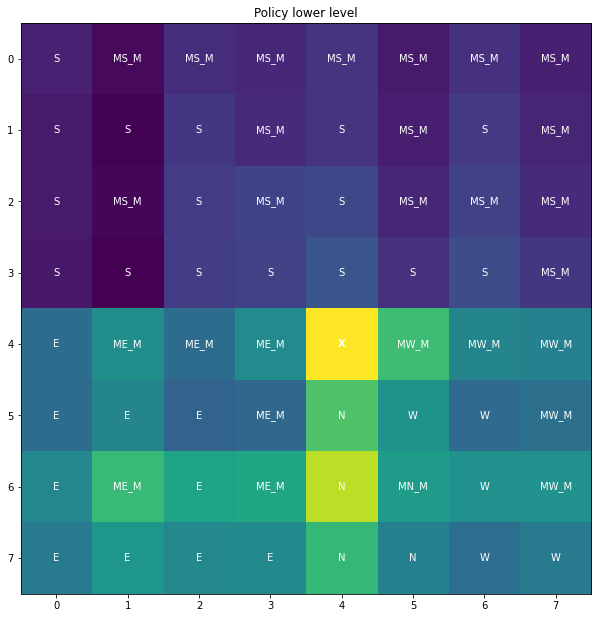

cccc
Exact
Parameter containing:
tensor([[1., 2., 4.]]) Parameter containing:
tensor([0.])
[1.0, 2.0, 4.0]
Ratio M/L: 2.0
[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'N']]
[[list([(0, -19.68153190612793), (1, -10.187191009521484), (2, -14.75798511505127), (3, -20.938840866088867)])
  list([(0, -23.318078994750977), (1, -10.322500228881836), (2, -16.471084594726562), (3, -16.720752716064453)])
  list([(0, -18.26339340209961), (1, -7.978264808654785), (2, -14.294721603393555), (3, -20.562881469726562)])
  list([(0, -19.325000762939453), (1, -9.678900718688965), (2, -15.599279403686523), (3, -18.17959976196289)])]
 [list([(0, -13.283105850219727), (1, -10.532876968383789), (2, -12.697856903076172), (3, -20.392019271850586)])
  list([(0, -14.649474143981934), (1, -9.739357948303223), (2, -13.854247093200684), (3, -13.063739776611328)])
  list([(0, -6.855845928192139), (1, -5.022467613220215), (2, -13.573407173156738), (3, -14.340620040893555)])
  list([(0, -

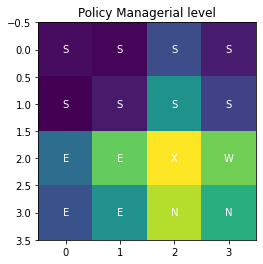

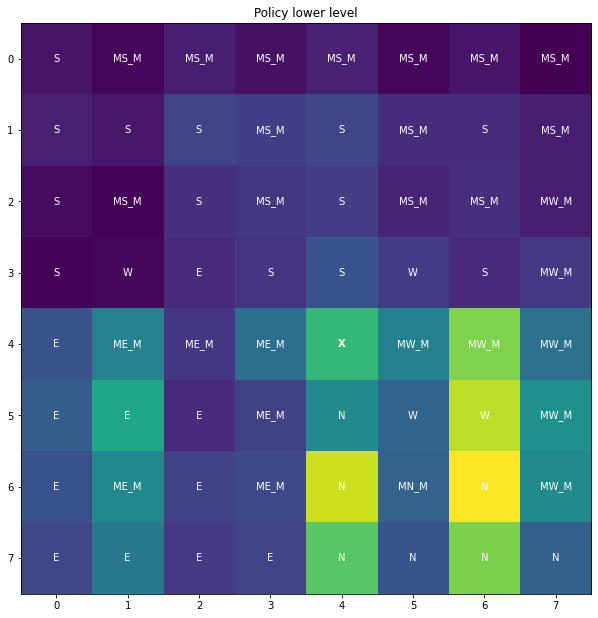

cccc
Learn 5.12
Init 5.01
Nil 5.27
Exact 5.17


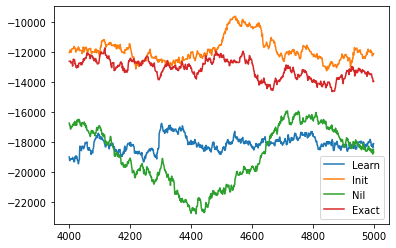

Learn 5.12
Init 5.01
Nil 5.27
Exact 5.17


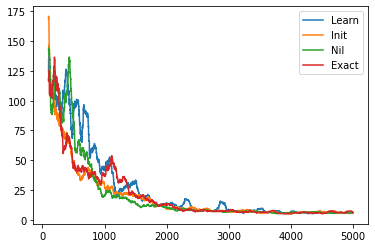

Learn -49.71
Init -25.74
Nil -45.42
Exact -26.78


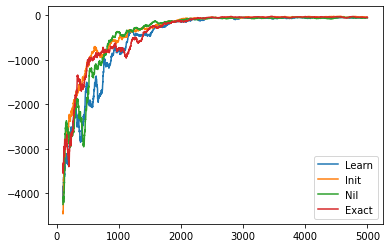

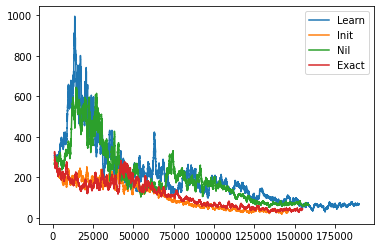

In [23]:
for x in range(4):
    labelp=r_dict_6[x]['man_init']
    nn=r_dict_6[x]['Q_policy']
    out=[]
    
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print_policy(nn, env4, 0, 0)
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_6[x]['man_init']
    
    print(labelp,pd.Series(r_dict_6[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_6[x]['rewards']).rolling(300).sum().tail(1000).plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_6[x]['man_init']
    
    print(labelp,pd.Series(r_dict_6[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_6[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_6[x]['man_init']
    print(labelp,pd.Series(r_dict_6[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_6[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_6[x]['man_init']
    pd.Series(r_dict_6[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

Init 22.200158096338033
Nil 22.88762447284077
Exact 19.986174420386465
Learn 25.51496598204514


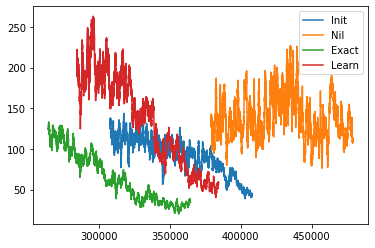

In [122]:
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().tail(100000).plot(label=labelp)
    print(labelp,pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().min())
plt.legend()

In [64]:
np.array([pd.Series(r_dict_3[x]['losses']) for x in range(4)])

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([0           0.944539
1           4.000000
2         116.894913
3           0.962077
4           0.956444
             ...    
395262      1.541258
395263      4.000000
395264      8.323048
395265     36.082764
395266      7.426988
Length: 395267, dtype: float64,
       0           0.868928
1           0.853750
2           8.439255
3         121.108536
4           0.979999
             ...    
354883      1.000000
354884      0.233869
354885      5.187146
354886     46.029171
354887      6.011152
Length: 354888, dtype: float64,
       0           1.006482
1           1.007505
2           9.000000
3         117.600548
4           0.837997
             ...    
377156     13.437597
377157      3.808572
377158    231.068237
377159     29.945692
377160     15.245069
Length: 377161, dtype: float64,
       0           0.972997
1           4.000000
2         121.008476
3           0.829128
4           3.806385
             ...    
392085    179.027435
392086      1.000000
392087      8.5

In [23]:
pd.Series(losses).rolling(999).mean().tail(1).values[0]

96.32986692258063

In [24]:
import collections

In [25]:
a=collections.Counter([tuple(x) for x in ss])

<AxesSubplot:>

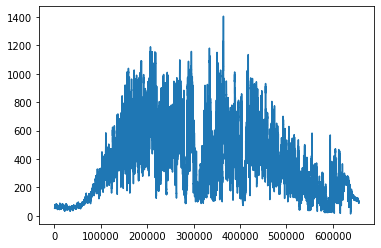

In [26]:
pd.Series(losses).rolling(500).mean().plot()

In [27]:
Q_policy

QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [24]:
for e in [env1,env2,env3]:
    plt.imshow(e.maze())

#

NameError: name 'env1' is not defined

In [27]:
env2

NameError: name 'env2' is not defined

In [29]:
Q_policy.man_layer.weight


Parameter containing:
tensor([[ 0.0246, -0.4764, -0.5448]], requires_grad=True)

In [30]:
for i in range(3):
    x=torch.zeros(3)
    x[i]=1
#     ([0.,0.,1.]
    print(Q_policy.man_layer(x))


tensor([-0.3883], grad_fn=<AddBackward0>)
tensor([-0.8894], grad_fn=<AddBackward0>)
tensor([-0.9577], grad_fn=<AddBackward0>)


In [31]:
pd.Series(episode_durations).rolling(100).mean().idxmin()

8885

In [32]:
Q_policy

QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [33]:
PATH = "C:/Users/howar/AppData/Local/Programs/netron"
torch.save(Q_policy.state_dict(), os.path.join(PATH,"filename.pth"))

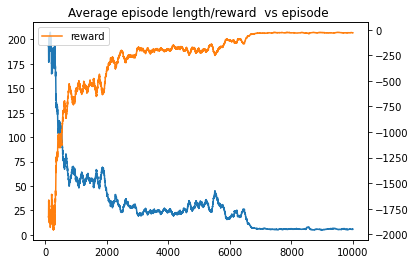

In [15]:

pd.Series(episode_durations).rolling(100).mean().plot(label='episode duration')
pd.Series(rewards).rolling(100).mean().plot(secondary_y=True,label='reward')
plt.title('Average episode length/reward  vs episode ')
plt.legend()

In [16]:
pd.Series(episode_durations).rolling(100).mean().idxmin()

8739

In [17]:
pd.Series(episode_durations).rolling(100).mean().min()

4.97

In [18]:
pd.Series(rewards).rolling(100).mean().max()

-23.61

In [19]:
pd.Series(rewards).rolling(100).mean().idxmax()

9525

In [20]:
a=pd.Series(rewards).rolling(100).mean()-pd.Series(rewards).rolling(100).mean().shift(-100)

In [89]:
a.tail(3000).idxmin()

7326

<AxesSubplot:>

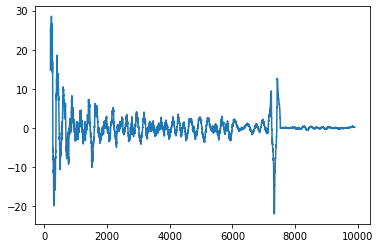

In [90]:
a.diff().rolling(100).mean().plot()

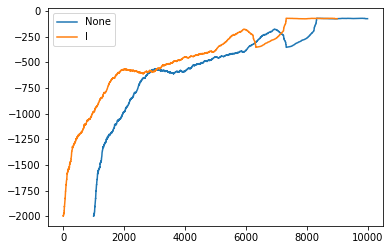

In [91]:
pd.Series(rewards).rolling(1000).mean().plot()
pd.Series(rewards).rolling(1000).mean().shift(-1000).plot(label='l')
plt.legend()

In [92]:
pd.Series(rewards).rolling(100).mean().max()

-53.25

In [93]:
pd.Series(rewards).rolling(50).mean()

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
9995   -73.68
9996   -73.98
9997   -73.98
9998   -74.94
9999   -75.36
Length: 10000, dtype: float64

In [127]:
Q_policy.man_layer.weight

Parameter containing:
tensor([[ 0.0246, -0.5033, -0.5646]], requires_grad=True)